<a href="https://colab.research.google.com/github/thc1006/flora-dp-federated-ColO-RAN/blob/main/0701_FLORA_DP_client_15_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Cell 1: Áí∞Â¢ÉË®≠ÂÆöËàáÂáΩÂºèÂ∫´ÂåØÂÖ•Ôºà‰øÆÊ≠£ÁâàÔºâ
!pip install --upgrade opacus -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader

# --- Áí∞Â¢ÉË®≠ÂÆö ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

print("‚úÖ Cell 1: Áí∞Â¢ÉËàáÂáΩÂºèÂ∫´Ê∫ñÂÇôÂ∞±Á∑í„ÄÇ")
import opacus
print(f"PyTorch/Opacus ÁâàÊú¨: {torch.__version__} / {opacus.__version__}")
print(f"CUDA ÊòØÂê¶ÂèØÁî®: {torch.cuda.is_available()}")


‚úÖ Cell 1: Áí∞Â¢ÉËàáÂáΩÂºèÂ∫´Ê∫ñÂÇôÂ∞±Á∑í„ÄÇ
PyTorch/Opacus ÁâàÊú¨: 2.6.0+cu124 / 1.5.4
CUDA ÊòØÂê¶ÂèØÁî®: True


In [ ]:
# @title Cell 2: üéì ÂØ¶È©óÂèÉÊï∏Ë®≠ÂÆöÔºàËôõÊì¨ÂÆ¢Êà∂Á´ØÂÑ™ÂåñÁâàÔºâ
from dataclasses import dataclass, field  # „Äê‰øÆÊ≠£„ÄëÊ∑ªÂä† field Â∞éÂÖ•
import os
import json
import torch
import numpy as np
from typing import Tuple

@dataclass
class TrainingConfig:
    experiment_name: str
    output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 20

    # „Äê‰øÆÊîπ5„ÄëËôõÊì¨ÂÆ¢Êà∂Á´ØÊì¥Â¢ûÈÖçÁΩÆ
    base_client_pairs: tuple = ((1, 2), (3, 7), (5, 6))  # ÂéüÂßã3Â∞çÂü∫Á´ô
    virtual_expansion_factor: int = 3  # ÊØèÂÄãÂü∫Á´ôÁµÑÂêàÁîüÊàê3ÂÄãËôõÊì¨ÂÆ¢Êà∂Á´Ø
    num_virtual_clients: int = 9       # 3√ó3 = 9ÂÄãËôõÊì¨ÂÆ¢Êà∂Á´Ø
    num_real_clients: int = 3          # ÂéüÂßãÁúüÂØ¶ÂÆ¢Êà∂Á´Ø
    total_clients: int = 12            # Á∏ΩË®à12ÂÄãÂÆ¢Êà∂Á´Ø
    num_clients: int = 12              # ÂØ¶ÈöõÂèÉËàáÁöÑÂÆ¢Êà∂Á´ØÊï∏Èáè
    num_clients_to_select: int = 8     # ÊØèËº™ÈÅ∏ÊìáÂèÉËàáÁöÑÂÆ¢Êà∂Á´ØÊï∏Èáè

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂèÉÊï∏
    temporal_split_method: str = "sliding_window"  # ÊôÇÈñìÁ™óÂè£ÂàÜÂâ≤
    noise_injection_std: float = 0.03  # Ê∑ªÂä†Â∑ÆÂàÜÈö±ÁßÅÂèãÂ•ΩÁöÑÂô™ËÅ≤
    feature_augmentation: bool = True   # ÁâπÂæµÂ¢ûÂº∑
    cross_validation_split: bool = True # ‰∫§ÂèâÈ©óË≠âÂàÜÂâ≤

    # „Äê‰øÆÊîπ4„ÄëÊîæÂ§ßÊú¨Âú∞ÊâπÊ¨°ËàáÂõûÂêà
    local_episodes_per_round: int = 4  # 6 ‚Üí 12
    steps_per_episode: int = 500        # 300 ‚Üí 600
    batch_size: int = 256              # 64 ‚Üí 256
    gamma: float = 0.99

    # Â≠∏ÁøíÂèÉÊï∏
    lr: float = 1e-4
    target_update_freq: int = 15

    # RL Êé¢Á¥¢ÂèÉÊï∏
    epsilon_start: float = 1.0
    epsilon_decay: float = 0.9995
    epsilon_min: float = 0.05

    # Ë®òÊÜ∂ËàáÂõûÊîæÔºàÊì¥Â¢û‰ª•ÈÖçÂêàÂ§ßÊâπÊ¨°Ôºâ
    memory_capacity: int = 50000       # 50000 ‚Üí 100000
    replay_start_size: int = 1000       # 1000 ‚Üí 2000
    replay_frequency: int = 2
    replay_batches_per_call: int = 3    # 2 ‚Üí 3

    # „Äê‰øÆÊîπ6„ÄëË™øÈ´òFedProxÊ≠£ÂâáÂåñÂº∑Â∫¶
    fedprox_mu: float = 0.15           # 0.01 ‚Üí 0.15
    num_clusters: int = 3              # ÈÖçÂêàÂÆ¢Êà∂Á´ØÊï∏ÈáèË™øÊï¥
    cluster_update_freq: int = 8       # 15 ‚Üí 8ÔºåÊõ¥È†ªÁπÅÊõ¥Êñ∞

    # „Äê‰øÆÊîπ1&4„ÄëÂ∑ÆÂàÜÈö±ÁßÅÂèÉÊï∏ÂÑ™Âåñ
    enable_dp: bool = True
    dp_target_epsilon: float = 8.0
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 0.5   # 0.7 ‚Üí 0.5ÔºàÈÖçÂêàÂ§ßÊâπÊ¨°Ôºâ
    dp_sampling_probability: float = 0.1  # 0.05 ‚Üí 0.1
    dp_virtual_batch_size: int = 256   # 64 ‚Üí 256
    dp_microbatch_size: int = 1

    # „Äê‰øÆÊîπ2„ÄëÈáçË®≠Ê©üÂà∂ÂèÉÊï∏
    dp_reset_threshold_multiplier: float = 1.5  # Ë∂ÖÈÅé1.5√ótarget_epsilonÊôÇÈáçË®≠
    enable_dp_reset: bool = True

    # ÂäüËÉΩÈñãÈóú
    enable_heterogeneity: bool = True
    enable_compression: bool = True

    # Á≥ªÁµ±Ë®≠ÂÆö
    straggler_ratio: float = 0.1
    dropout_ratio: float = 0.05
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True
    local_finetune_episodes: int = 15
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    # ÂÖºÂÆπÊÄßÂèÉÊï∏Ôºà‰øùÊåÅÂêëÂæåÂÖºÂÆπÔºâ
    client_pairs: tuple = field(init=False)  # Â∞áÂú® __post_init__ ‰∏≠Ë®≠ÂÆö

    def __post_init__(self):
        # ÂãïÊÖãÁîüÊàêÂÆ¢Êà∂Á´ØÈÖçÂ∞çÔºàÁî®ÊñºÂÖºÂÆπÊÄßÔºâ
        extended_client_pairs = []
        for i in range(self.total_clients):
            embb_id = i + 1
            urllc_id = i + 2
            extended_client_pairs.append((embb_id, urllc_id))
        self.client_pairs = tuple(extended_client_pairs)

        # GPU Áí∞Â¢ÉÊ™¢Ê∏¨
        if torch.cuda.is_available():
            if "L4" in torch.cuda.get_device_name(0):
                print(f"üöÄ L4 GPUÊ™¢Ê∏¨Âà∞ÔºåÂïüÁî®Â§ßÊâπÊ¨°ÂÑ™ÂåñÈÖçÁΩÆ")

        # Â∑ÆÂàÜÈö±ÁßÅÊ®°ÂºèÊ™¢Ê∏¨
        if self.mode == 'Centralized':
            self.enable_dp = False

        # ÈÖçÁΩÆ‰ø°ÊÅØÈ°ØÁ§∫
        print(f"üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØÈÖçÁΩÆ:")
        print(f"   - ÁúüÂØ¶Âü∫Á´ôÂ∞ç: {len(self.base_client_pairs)} ({self.base_client_pairs})")
        print(f"   - Êì¥Â¢ûÂõ†Â≠ê: {self.virtual_expansion_factor}")
        print(f"   - Á∏ΩÂÆ¢Êà∂Á´ØÊï∏: {self.total_clients} (ÁúüÂØ¶: {self.num_real_clients}, ËôõÊì¨: {self.num_virtual_clients})")
        print(f"   - ÊØèËº™ÂèÉËàá: {self.num_clients_to_select}")

        if self.enable_dp and self.mode != 'Centralized':
            print(f"üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÂ∑≤ÂïüÁî®ÔºàGDP/PRV Accountant + Poisson SamplingÔºâ")
            print(f"   - ÁõÆÊ®ôÈö±ÁßÅÈ†êÁÆó: Œµ={self.dp_target_epsilon}")
            print(f"   - ÊâπÊ¨°Â§ßÂ∞è: {self.batch_size}")
            print(f"   - Âô™ËÅ≤‰πòÊï∏: {self.dp_noise_multiplier}")
            print(f"   - ÈáçË®≠Ê©üÂà∂: {'ÂïüÁî®' if self.enable_dp_reset else 'Á¶ÅÁî®'}")
        else:
            print(f"üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÔºöÁ¶ÅÁî®ÔºàÊ®°Âºè: {self.mode}Ôºâ")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in self.__dict__.items()}
        with open(path, 'w') as f:
            json.dump(config_dict, f, indent=4)
        print(f"‚úÖ ÈÖçÁΩÆÂ∑≤‰øùÂ≠òËá≥: {path}")

print("‚úÖ Cell 2: TrainingConfigÔºàËôõÊì¨ÂÆ¢Êà∂Á´ØÂÑ™ÂåñÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 2: TrainingConfigÔºàËôõÊì¨ÂÆ¢Êà∂Á´ØÂÑ™ÂåñÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 3: üß© Êï∏ÊìöËàáÁí∞Â¢ÉÊ∫ñÂÇôÔºà‰øÆÊ≠£ÁâàÔºâ
class DataManager:
    def __init__(self, data_path, client_pairs_config):
        print(f"\n[DataManager] Ê≠£Âú®Âæû {data_path} ËÆÄÂèñÊï∏Êìö...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self._sanitize_column_names(); self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\[\]\(\)%\s\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager ÂïüÂãïÂâçÈ†êÊ™¢Êü• " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± {len(cols)} ÂÄã):")
        print(f"   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: '{self.tput_col}'" if self.tput_col
              else "   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÂåπÈÖçÂ§±ÊïóÔºÅ")
        print(f"   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: '{self.lat_col}'" if self.lat_col
              else "   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÂåπÈÖçÂ§±ÊïóÔºÅ")

        # ‰øÆÊ≠£ÔºöÊ™¢Êü•BSÁØÄÈªûÁöÑÂØ¶ÈöõÂèØÁî®ÊÄß
        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - ÂèØÁî®BSÁØÄÈªû: {available_bs}")

        # È©óË≠âÂÆ¢Êà∂Á´ØÈÖçÂ∞çÁöÑÊúâÊïàÊÄß
        for i, (embb_bs, urllc_bs) in enumerate(self.client_pairs_config):
            if embb_bs not in available_bs or urllc_bs not in available_bs:
                raise ValueError(f"ÂÆ¢Êà∂Á´Ø {i} ÁöÑBSÈÖçÂ∞ç ({embb_bs}, {urllc_bs}) ‰∏≠ÂåÖÂê´‰∏çÂ≠òÂú®ÁöÑBSÁØÄÈªû")
        print("   - ÂÆ¢Êà∂Á´ØBSÈÖçÂ∞çÈ©óË≠âÈÄöÈÅé")
        print("="*65 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("È†êÊ™¢Êü•Â§±Êïó: Êâæ‰∏çÂà∞ÂøÖË¶ÅÁöÑÊï∏ÊìöÊ¨Ñ‰Ωç„ÄÇ")

    def _get_clean_df(self, gnb_id, slice_id):
        """‰øÆÊ≠£ÁâàÔºöÂ¢ûÂä†Êõ¥Âö¥Ê†ºÁöÑÊï∏ÊìöÈÅéÊøæÂíåÈ©óË≠â"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        # Á¢∫‰øùÊï∏ÊìöÈ°ûÂûã‰∏ÄËá¥ÊÄß
        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        # ‰øÆÊ≠£ÔºöÊõ¥Âö¥Ê†ºÁöÑÊï∏ÊìöÊ∏ÖÁêÜ
        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        # ÁßªÈô§Áï∞Â∏∏ÂÄºÔºàË∂ÖÂá∫ÂêàÁêÜÁØÑÂúçÁöÑÊï∏ÊìöÈªûÔºâ
        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &  # ÂêûÂêêÈáèÁØÑÂúç
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)  # Âª∂ÈÅ≤ÁØÑÂúç
            ]

        return subset

    def get_client_trajectories(self):
        """‰øÆÊ≠£ÁâàÔºöÁ¢∫‰øùÂÆ¢Êà∂Á´ØÊï∏ÊìöÂÆåÂÖ®Áç®Á´ã"""
        client_trajectories = {}
        print("[DataManager] Ê≠£Âú®ÁÇ∫ÊØèÂÄãÂÆ¢Êà∂Á´ØÁîüÊàêÊï∏ÊìöËªåË∑°...")

        for i, (embb_id, urllc_id) in enumerate(tqdm(self.client_pairs_config, desc="ËôïÁêÜÂÆ¢Êà∂Á´ØÊï∏Êìö")):
            try:
                # Á¢∫‰øùÊØèÂÄãÂÆ¢Êà∂Á´Ø‰ΩøÁî®‰∏çÂêåÁöÑBSÔºåÁ∂≠Ë≠∑Êï∏ÊìöÁç®Á´ãÊÄß
                df_embb = self._get_clean_df(embb_id, 0)  # eMBBÂàáÁâá
                df_urllc = self._get_clean_df(urllc_id, 2)  # URLLCÂàáÁâá

                if df_embb.empty or df_urllc.empty:
                    print(f"üü° Ë≠¶Âëä: ÂÆ¢Êà∂Á´Ø {i} (BS {embb_id}/{urllc_id}) ÁØ©ÈÅ∏ÂæåÁÑ°ÊúâÊïàÊï∏Êìö„ÄÇ")
                    client_trajectories[i] = np.array([])
                    continue

                # ‰øÆÊ≠£Ôºö‰ΩøÁî®Êõ¥‰øùÂÆàÁöÑÊôÇÈñìÂÆπÂøçÂ∫¶ÔºåÈÅøÂÖçÊï∏ÊìöÊ¥©Êºè
                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',  # Á¢∫‰øùÂè™‰ΩøÁî®ÈÅéÂéªÁöÑ‰ø°ÊÅØ
                    tolerance=pd.Timedelta('100ms'),  # Ê∏õÂ∞ëÂÆπÂøçÂ∫¶
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if merged_df.empty:
                    print(f"üü° Ë≠¶Âëä: ÂÆ¢Êà∂Á´Ø {i} Âêà‰ΩµÂæåÁÑ°ÊúâÊïàÊï∏Êìö„ÄÇ")
                    client_trajectories[i] = np.array([])
                    continue

                # Á¢∫‰øùÊï∏ÊìöÂ∫èÂàóÁöÑÊôÇÈñìÈ†ÜÂ∫èÊÄß
                merged_df = merged_df.sort_values('timestamp').reset_index(drop=True)
                trajectory = merged_df[['throughput_embb', 'latency_embb',
                                      'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)

                client_trajectories[i] = trajectory
                print(f"   - ÂÆ¢Êà∂Á´Ø {i}: {len(trajectory)} ÂÄãÊôÇÈñìÊ≠•")

            except Exception as e:
                print(f"‚ùå ÈåØË™§: ËôïÁêÜÂÆ¢Êà∂Á´Ø {i} ÊôÇÁôºÁîüÂö¥ÈáçÈåØË™§: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] Êï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ {num_valid} / {len(self.client_pairs_config)} ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ")
        return client_trajectories

print("‚úÖ Cell 3: DataManagerÔºà‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 3: DataManagerÔºà‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 4: ‚ö° RLÁí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºà‰øÆÊ≠£ GPU Ë®≠ÂÇôËôïÁêÜÔºâ
import gc
import time
import os
import torch
import numpy as np
import pandas as pd
import contextlib
from collections import deque
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

class PairedEnv:
    """ÈÖçÂ∞çÁí∞Â¢ÉÈ°ûÂà• - ‰øùÊåÅ‰∏çËÆä‰ΩÜÂä†ÂÖ•GPUÂÑ™ÂåñÊ®ôË®ò"""
    def __init__(self, trajectory, config: TrainingConfig):
        self.trajectory, self.config = trajectory, config
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3
        self.cursor = 0
        self.reset()

    def reset(self):
        if self.trajectory.size == 0:
            return np.zeros(self.state_size, dtype=np.float32)
        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0:
            self.cursor = np.random.randint(0, max_start)
        else:
            self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}
        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        tput_embb, lat_embb, tput_urllc, lat_urllc = state
        if action_id == 0: w_tput, w_lat = (0.7, 0.3)
        elif action_id == 2: w_tput, w_lat = (0.3, 0.7)
        else: w_tput, w_lat = (0.5, 0.5)
        tput_reward = w_tput * (np.log1p(tput_embb) + 0.5 * np.log1p(tput_urllc))
        lat_penalty = w_lat * (np.tanh(lat_urllc * 1e-6) + 0.3 * np.tanh(lat_embb * 1e-6))
        reward_val = tput_reward - lat_penalty
        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    """RLÊï∏ÊìöÈõÜÈ°ûÂà• - GPUÂÑ™ÂåñÁâàÊú¨"""
    def __init__(self, memory_list):
        self.data = memory_list[:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (
            torch.from_numpy(state).float(),
            torch.tensor(action).long(),
            torch.tensor(reward).float(),
            torch.from_numpy(next_state).float(),
            torch.tensor(done).bool()
        )

def get_gpu_optimized_data_loader(agent_memory: deque, batch_size: int, device: str):
    """
    üî• GPUÊÄßËÉΩÂÑ™ÂåñÁöÑÊï∏ÊìöÂä†ËºâÂô®Ôºà‰øÆÊ≠£Ë®≠ÂÇôËôïÁêÜÔºâ
    """
    if len(agent_memory) < batch_size:
        return None

    try:
        dataset = RLDataset(list(agent_memory))

        # Á¢∫ÂÆö worker Êï∏Èáè
        cpu_count = os.cpu_count() or 4
        if cpu_count <= 2:
            num_workers = 0  # T4 ÈÄöÂ∏∏Âè™Êúâ 2 CPUÔºå‰ΩøÁî®ÂñÆÁ∑öÁ®ã
        else:
            num_workers = min(2, cpu_count // 2)

        # DataLoader ÈÖçÁΩÆ
        dataloader_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': True,
            'num_workers': num_workers,
            'pin_memory': torch.cuda.is_available() and device == 'cuda',
            'drop_last': True,
        }

        # Âè™Âú®Êúâ worker ÊôÇÊ∑ªÂä† persistent_workers
        if num_workers > 0:
            dataloader_kwargs['persistent_workers'] = True
            dataloader_kwargs['prefetch_factor'] = 2

        # Ë®≠ÂÆöÊ≠£Á¢∫ÁöÑ generator
        if device == 'cuda' and torch.cuda.is_available():
            # ÁÇ∫ CUDA Ë®≠ÂÇôÂâµÂª∫ generator
            g = torch.Generator(device='cuda')
            g.manual_seed(42)
            dataloader_kwargs['generator'] = g

        return DataLoader(**dataloader_kwargs)

    except Exception as e:
        print(f"üö® GPUÂÑ™ÂåñDataLoaderÂâµÂª∫Â§±Êïó: {e}")
        print(f"   ÂõûÈÄÄÂà∞Âü∫Êú¨Ë®≠ÂÆö...")

        try:
            # Á∞°ÂåñË®≠ÂÆöÔºå‰∏ç‰ΩøÁî® generator
            return DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=False,
                drop_last=True
            )
        except Exception as e2:
            print(f"üö® ÂõûÈÄÄ‰πüÂ§±Êïó: {e2}")
            return None

def setup_gpu_environment():
    """
    üöÄ Áµ±‰∏ÄÁöÑGPUÁí∞Â¢ÉË®≠ÂÆöÂáΩÊï∏
    """
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        compute_capability = torch.cuda.get_device_properties(0).major
        cpu_count = os.cpu_count() or 4

        print(f"üéÆ GPU Ê™¢Ê∏¨: {gpu_name}")
        print(f"üìä Á∏ΩË®òÊÜ∂È´î: {total_memory:.1f} GB")
        print(f"üîß Ë®àÁÆóËÉΩÂäõ: {compute_capability}.x")
        print(f"üíª ÂèØÁî®CPUÊï∏: {cpu_count}")

        # Ë®≠ÂÆö CUDA ÈÖçÁΩÆ
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Ê∏ÖÁêÜË®òÊÜ∂È´î
        torch.cuda.empty_cache()
        gc.collect()

        print(f"üßπ GPUÁí∞Â¢ÉË®≠ÂÆöÂÆåÊàê")
    else:
        print("‚ö†Ô∏è Êú™Ê™¢Ê∏¨Âà∞GPUÔºåÂ∞á‰ΩøÁî®CPUÊ®°ÂºèÈÅãË°å")

# ÂÖ∂‰ªñÂáΩÊï∏‰øùÊåÅ‰∏çËÆä
def create_gpu_scaler():
    """ÂâµÂª∫GPUÊ∑∑ÂêàÁ≤æÂ∫¶Á∏ÆÊîæÂô®"""
    if torch.cuda.is_available():
        return GradScaler()
    return None

def optimize_batch_processing(states, actions, rewards, next_states, dones, device):
    """ÊâπÊ¨°ËôïÁêÜÂÑ™ÂåñÂáΩÊï∏"""
    states_gpu = states.to(device, non_blocking=True)
    actions_gpu = actions.to(device, non_blocking=True)
    rewards_gpu = rewards.to(device, non_blocking=True)
    next_states_gpu = next_states.to(device, non_blocking=True)
    dones_gpu = dones.to(device, non_blocking=True)
    return states_gpu, actions_gpu, rewards_gpu, next_states_gpu, dones_gpu

print("‚úÖ Cell 4: RLÁí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºà‰øÆÊ≠£ GPU Ë®≠ÂÇôËôïÁêÜÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 4: RLÁí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºà‰øÆÊ≠£ GPU Ë®≠ÂÇôËôïÁêÜÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 5: üõ°Ô∏è Ê†∏ÂøÉÂ≠∏Áøí‰ª£ÁêÜÔºàÂÆåÊï¥ÁâàÔºåÂåÖÂê´GPUÂÑ™ÂåñÔºâ
import gc
import time
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params = None
        self.is_eval_agent = is_eval_agent
        self.privacy_engine = None
        self.dp_steps = 0
        self.current_epsilon = 0.0
        self.current_best_alpha = None
        self.consecutive_errors = 0
        self.max_consecutive_errors = 5

        # „ÄêÂ¢ûÂº∑ÈåØË™§ËôïÁêÜ„ÄëÈö±ÁßÅË®àÁÆóÂ§±ÊïóËøΩËπ§
        self.privacy_calc_failures = 0
        self.last_valid_epsilon = 0.0
        self.dp_reset_count = 0
        self.last_reset_round = -1
        self.original_optimizer_class = optim.Adam

        self.model = self._build_dp_model()
        self.target_model = self._build_dp_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = self.original_optimizer_class(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._initialize_dp_engine()
        else:
            print(f"[C-{self.client_id}] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ")

    def _build_dp_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, self.action_size)
        ).to(self.device)
        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)
        return model

    def _initialize_dp_engine(self):
        """„ÄêÁ©©ÂÆöÊÄßÂ¢ûÂº∑Áâà„ÄëÂ∑ÆÂàÜÈö±ÁßÅÂºïÊìéÂàùÂßãÂåñ"""
        print(f"[C-{self.client_id}] üõ°Ô∏è ÂàùÂßãÂåñÂ∑ÆÂàÜÈö±ÁßÅÂºïÊìé...")

        # ÂàùÂßãÂåñÂ§±ÊïóË®àÊï∏Âô®
        self.privacy_calc_failures = 0
        self.last_valid_epsilon = 0.0

        try:
            # Ê∏ÖÁêÜËàäÂºïÊìé
            if hasattr(self, 'privacy_engine') and self.privacy_engine is not None:
                del self.privacy_engine
                torch.cuda.empty_cache()
                gc.collect()

            # ÈáçÂª∫Ê®°ÂûãÂíåÂÑ™ÂåñÂô®
            self.model = self._build_dp_model()
            self.optimizer = self.original_optimizer_class(self.model.parameters(), lr=self.config.lr)

            # ÂâµÂª∫ËôõÊì¨Êï∏ÊìöÈõÜ
            dummy_data = []
            effective_dataset_size = max(self.dataset_size, self.config.batch_size * 10)

            for _ in range(effective_dataset_size):
                state = np.random.randn(self.state_size).astype(np.float32)
                action = int(np.random.randint(0, 3))
                reward = float(np.random.randn())
                next_state = np.random.randn(self.state_size).astype(np.float32)
                done = bool(np.random.choice([True, False]))
                dummy_data.append((state, action, reward, next_state, done))

            dummy_dataset = RLDataset(dummy_data)
            dummy_loader = DataLoader(
                dummy_dataset, batch_size=self.config.batch_size, num_workers=0, shuffle=True
            )

            # „ÄêÂ¢ûÂº∑„ÄëÂ§öÈáç accountant ÂõûÈÄÄÊ©üÂà∂
            accountant_options = [
                ("gdp", "GDP"),
                ("prv", "PRV"),
                ("rdp", "RDP"),
                (None, "Default")
            ]

            for accountant_type, type_name in accountant_options:
                try:
                    if accountant_type:
                        self.privacy_engine = PrivacyEngine(accountant=accountant_type)
                    else:
                        self.privacy_engine = PrivacyEngine()

                    print(f"   - ÂòóË©¶ Accountant: {type_name}")
                    break

                except Exception as e:
                    print(f"   - {type_name} Accountant Â§±Êïó: {e}")
                    continue

            if not self.privacy_engine:
                raise RuntimeError("ÊâÄÊúâ Accountant È°ûÂûãÈÉΩÂ§±Êïó")

            # ÂãïÊÖã sample_rate Ë®àÁÆó
            sample_rate = min(self.config.batch_size / len(dummy_data), 1.0)
            print(f"   - Sample Rate: {sample_rate:.6f}")

            self.model, self.optimizer, dummy_loader = self.privacy_engine.make_private(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=dummy_loader,
                noise_multiplier=self.config.dp_noise_multiplier,
                max_grad_norm=self.config.dp_max_grad_norm,
                poisson_sampling=True
            )

            # ÈáçË®≠Ë®àÊï∏Âô®
            self.dp_steps = 0
            self.current_epsilon = 0.0
            self.current_best_alpha = None

            print(f"   - ‚úÖ Â∑ÆÂàÜÈö±ÁßÅÂºïÊìéÂàùÂßãÂåñÊàêÂäü")
            print(f"   - Âô™ËÅ≤‰πòÊï∏: {self.config.dp_noise_multiplier}")
            print(f"   - Ê¢ØÂ∫¶Ë£ÅÂâ™: {self.config.dp_max_grad_norm}")
            print(f"   - PoissonÊé°Ê®£: True")

        except Exception as e:
            print(f"   - ‚ùå Â∑ÆÂàÜÈö±ÁßÅÂàùÂßãÂåñÂ§±Êïó: {e}")
            print(f"   - üîÑ ÂàáÊèõÂà∞ÈùûÂ∑ÆÂàÜÈö±ÁßÅÊ®°Âºè")
            self.privacy_engine = None
            self.privacy_calc_failures = 999  # Ê®ôË®òÁÇ∫Ê∞∏‰πÖÂ§±ÊïóÁãÄÊÖã

    def reset_dp_engine(self, round_num: int):
        """„ÄêÂÆåÂÖ®‰øÆÊ≠£2„ÄëÊ≠£Á¢∫ÁöÑDPÂºïÊìéÈáçË®≠ÊñπÊ≥ï"""
        if not self.config.enable_dp_reset or not self.privacy_engine:
            return False

        print(f"[C-{self.client_id}] üîÑ ÈáçË®≠Â∑ÆÂàÜÈö±ÁßÅÂºïÊìéÔºàRound {round_num}Ôºâ...")
        try:
            # Ë®òÈåÑÈáçË®≠Ë≥áË®ä
            self.dp_reset_count += 1
            self.last_reset_round = round_num
            old_epsilon = self.current_epsilon

            # ÈáçÊñ∞ÂàùÂßãÂåñÊï¥ÂÄãengine
            self._initialize_dp_engine()

            print(f"   - ‚úÖ ÈáçË®≠ÂÆåÊàêÔºàÁ¨¨{self.dp_reset_count}Ê¨°Ôºâ")
            print(f"   - ËàäŒµ: {old_epsilon:.4f} ‚Üí Êñ∞Œµ: {self.current_epsilon:.4f}")
            return True
        except Exception as e:
            print(f"   - ‚ùå ÈáçË®≠Â§±Êïó: {e}")
            return False

    def get_privacy_cost(self):
        """„ÄêÂ¢ûÂº∑Áâà„ÄëÈö±ÁßÅÊàêÊú¨Ë®àÁÆóÔºåÂ§öÈáçÈåØË™§ËôïÁêÜÊ©üÂà∂"""
        if not self.privacy_engine:
            return 0.0

        # Â¶ÇÊûú‰πãÂâçË®àÁÆóÂ§±ÊïóÂ§™Â§öÊ¨°ÔºåÁõ¥Êé•ËøîÂõûÁ∑©Â≠òÂÄº
        if hasattr(self, 'privacy_calc_failures') and self.privacy_calc_failures > 10:
            return getattr(self, 'last_valid_epsilon', 0.0)

        try:
            # „ÄêÊñπÊ≥ï1„ÄëÂòóË©¶Ê®ôÊ∫ñ get_epsilon Ë™øÁî®
            result = self.privacy_engine.get_epsilon(delta=self.config.dp_target_delta)

            # ËôïÁêÜ‰∏çÂêåËøîÂõûÊ†ºÂºè
            if isinstance(result, tuple):
                if len(result) == 2:
                    epsilon, best_alpha = result
                    self.current_best_alpha = best_alpha
                else:
                    epsilon = result[0]
                    self.current_best_alpha = None
            elif isinstance(result, (int, float)):
                epsilon = result
                self.current_best_alpha = None
            else:
                raise ValueError(f"Êú™Áü•ÁöÑepsilonËøîÂõûÊ†ºÂºè: {type(result)}")

            # È©óË≠â epsilon ÂÄºÊúâÊïàÊÄß
            if np.isinf(epsilon) or np.isnan(epsilon) or epsilon < 0:
                raise ValueError(f"ÁÑ°ÊïàepsilonÂÄº: {epsilon}")

            # ÊàêÂäüË®àÁÆóÔºåÈáçÁΩÆÂ§±ÊïóË®àÊï∏
            if hasattr(self, 'privacy_calc_failures'):
                self.privacy_calc_failures = 0

            self.current_epsilon = float(epsilon)
            self.last_valid_epsilon = self.current_epsilon  # Á∑©Â≠òÊúâÊïàÂÄº
            return self.current_epsilon

        except Exception as primary_error:
            # Ë®òÈåÑÂ§±ÊïóÊ¨°Êï∏
            if not hasattr(self, 'privacy_calc_failures'):
                self.privacy_calc_failures = 0
            self.privacy_calc_failures += 1

            # „ÄêÊñπÊ≥ï2„ÄëÂòóË©¶‰ΩøÁî®Êõø‰ª£Ë®àÁÆóÊñπÊ≥ï
            try:
                # ‰ΩøÁî®Ê≠•Êï∏‰º∞ÁÆóÈö±ÁßÅÊàêÊú¨ÔºàÁ≤óÁï•‰º∞Ë®àÔºâ
                if hasattr(self, 'dp_steps') and self.dp_steps > 0:
                    # Âü∫ÊñºÂ∑≤Âü∑Ë°åÊ≠•Êï∏ÁöÑÁ∞°ÂñÆ‰º∞ÁÆó
                    estimated_epsilon = self.dp_steps * 0.01  # ÊØèÊ≠•Ê∂àËÄó0.01 epsilonÔºà‰øùÂÆà‰º∞Ë®àÔºâ
                    estimated_epsilon = min(estimated_epsilon, self.config.dp_target_epsilon)

                    if self.privacy_calc_failures <= 3:  # ÂâçÂπæÊ¨°Â§±ÊïóÊôÇÈ°ØÁ§∫Ë©≥Á¥∞‰ø°ÊÅØ
                        print(f"[C-{self.client_id}] ‚ö†Ô∏è Èö±ÁßÅÊàêÊú¨Ë®àÁÆóÂ§±Êïó: {primary_error}")
                        print(f"   üîÑ ‰ΩøÁî®‰º∞ÁÆóÂÄº: Œµ ‚âà {estimated_epsilon:.4f} (Âü∫Êñº {self.dp_steps} Ê≠•)")

                    self.current_epsilon = estimated_epsilon
                    return estimated_epsilon

            except Exception as fallback_error:
                if self.privacy_calc_failures <= 3:
                    print(f"[C-{self.client_id}] ‚ö†Ô∏è ÂÇôÁî®Èö±ÁßÅË®àÁÆó‰πüÂ§±Êïó: {fallback_error}")

            # „ÄêÊñπÊ≥ï3„ÄëÊúÄÁµÇÂõûÈÄÄÔºö‰ΩøÁî®Á∑©Â≠òÂÄºÊàñËøîÂõû0
            if hasattr(self, 'last_valid_epsilon'):
                cached_value = self.last_valid_epsilon
                if self.privacy_calc_failures <= 3:
                    print(f"[C-{self.client_id}] üîÑ ‰ΩøÁî®Á∑©Â≠òÈö±ÁßÅÂÄº: Œµ = {cached_value:.4f}")
                return cached_value

            # ÂÆåÂÖ®Â§±ÊïóÁöÑÊÉÖÊ≥Å
            if self.privacy_calc_failures <= 3:  # Âè™Âú®ÂâçÂπæÊ¨°Â§±ÊïóÊôÇÈ°ØÁ§∫
                print(f"[C-{self.client_id}] ‚ö†Ô∏è Èö±ÁßÅÊàêÊú¨Ë®àÁÆóÂÆåÂÖ®Â§±Êïó: {primary_error}")
                print(f"   üîÑ ËøîÂõû 0.0ÔºåË®ìÁ∑¥ÁπºÁ∫åÔºàÂ§±ÊïóÊ¨°Êï∏: {self.privacy_calc_failures}Ôºâ")
            elif self.privacy_calc_failures == 11:  # Â§±ÊïóÊ¨°Êï∏ÈÅéÂ§öÊôÇÁöÑ‰∏ÄÊ¨°ÊÄßÊèêÈÜí
                print(f"[C-{self.client_id}] ‚ö†Ô∏è Èö±ÁßÅË®àÁÆóÊåÅÁ∫åÂ§±ÊïóÔºåÂ∑≤ÂàáÊèõËá≥ÈùúÈªòÊ®°Âºè")

            return 0.0

    def get_privacy_detailed_info(self):
        """„ÄêÊñ∞Â¢û„ÄëÁç≤ÂèñË©≥Á¥∞Èö±ÁßÅË≥áË®ä‰æõÊó•Ë™åË®òÈåÑ"""
        return {
            'client_id': self.client_id,
            'epsilon': self.current_epsilon,
            'best_alpha': self.current_best_alpha,
            'dp_steps': self.dp_steps,
            'reset_count': self.dp_reset_count,
            'last_reset_round': self.last_reset_round,
            'calc_failures': getattr(self, 'privacy_calc_failures', 0),
            'last_valid_epsilon': getattr(self, 'last_valid_epsilon', 0.0)
        }

    def replay(self, num_batches: int):
        if len(self.memory) < self.config.batch_size:
            return 0.0

        data_loader = get_gpu_optimized_data_loader(
            self.memory, self.config.batch_size, self.device
        )
        if data_loader is None:
            return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        try:
            for i, batch in enumerate(data_loader):
                if i >= num_batches:
                    break

                self.optimizer.zero_grad()
                states, actions, rewards, next_states, dones = [item.to(self.device, non_blocking=True) for item in batch]

                current_q = self.model(states).gather(1, actions.view(-1, 1))
                with torch.no_grad():
                    max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards.view(-1, 1) + (self.gamma * max_next_q * (~dones.view(-1, 1)))

                loss = self.criterion(current_q, target_q)

                # „ÄêÊïàËÉΩÂÑ™Âåñ6„ÄëÂ¢ûÂº∑ÁöÑFedProxÊ≠£ÂâáÂåñÔºàŒº=0.15Ôºâ
                if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                    proximal_term = 0.0
                    model_params = self.model._module.parameters() if hasattr(self.model, '_module') else self.model.parameters()
                    for local_param, global_param in zip(model_params, self.global_params):
                        proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                    loss += (self.mu / 2) * proximal_term

                if not torch.isfinite(loss):
                    continue

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                batches_processed += 1
                if self.privacy_engine:
                    self.dp_steps += 1

            return total_loss / batches_processed if batches_processed > 0 else 0.0
        except Exception as e:
            print(f"[C-{self.client_id}] üö® ÂõûÊîæÈåØË™§: {e}")
            return 0.0

    # ÂÖ∂È§òÊñπÊ≥ï‰øùÊåÅ‰∏çËÆä...
    def remember(self, *args):
        self.memory.append(args)

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def get_clean_state_dict(self):
        return self.model._module.state_dict() if self.privacy_engine and hasattr(self.model, '_module') else self.model.state_dict()

    def update_target_model(self):
        self.target_model.load_state_dict(self.get_clean_state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
            return torch.cat([p.view(-1) for p in params]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()
        return {k: v.half() for k, v in state_dict.items()} if self.config.enable_compression else state_dict

print("‚úÖ Cell 5: RLAgentÔºàÂÆåÊï¥ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 5: RLAgentÔºàÂÆåÊï¥ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 5.5: üåê ËÅØÈÇ¶Â≠∏ÁøíÊúçÂãôÂô®È°ûÂà•ÔºàFLServerÔºâ
import torch
import numpy as np
from sklearn.cluster import KMeans
from typing import Dict, List, Tuple, Any
import copy

class FLServer:
    """
    ËÅØÈÇ¶Â≠∏ÁøíÊúçÂãôÂô®È°ûÂà•
    Ë≤†Ë≤¨Ê®°ÂûãËÅöÂêà„ÄÅÂÆ¢Êà∂Á´ØËÅöÈ°ûÂíåÊ®°ÂûãÂàÜÁôº
    """

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.num_clusters = config.num_clusters
        self.client_to_cluster = {}
        self.cluster_models = {}
        self.aggregation_weights = {}

        # ÂàùÂßãÂåñËÅöÈ°ûÊ®°Âûã
        for i in range(self.num_clusters):
            self.cluster_models[i] = None

        print(f"[FLServer] ÂàùÂßãÂåñÂÆåÊàê - ËÅöÈ°ûÊï∏: {self.num_clusters}")

    def distribute_model(self, participating_agents: Dict, global_model_state: Dict):
        """
        Â∞áÊ®°ÂûãÂàÜÁôºÁµ¶ÂèÉËàáÁöÑÂÆ¢Êà∂Á´Ø
        """
        for client_id, agent in participating_agents.items():
            if self.config.mode == 'ClusteredFL':
                # ËÅöÈ°ûËÅØÈÇ¶Â≠∏ÁøíÔºö‰ΩøÁî®Â∞çÊáâËÅöÈ°ûÁöÑÊ®°Âûã
                cluster_id = self.client_to_cluster.get(client_id, 0)
                if cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None:
                    model_to_send = self.cluster_models[cluster_id]
                else:
                    model_to_send = global_model_state
            else:
                # ÂÖ∂‰ªñÊ®°ÂºèÔºö‰ΩøÁî®ÂÖ®ÂüüÊ®°Âûã
                model_to_send = global_model_state

            # ËôïÁêÜÂ£ìÁ∏ÆÊ®°Âûã
            if self.config.enable_compression:
                model_to_send = {k: v.float() if hasattr(v, 'float') else v
                               for k, v in model_to_send.items()}

            # Ë®≠ÁΩÆÂÖ®ÂüüÂèÉÊï∏ÂíåËºâÂÖ•Ê®°Âûã
            agent.set_global_params(model_to_send)
            agent.model.load_state_dict(model_to_send)

    def aggregate_weighted(self, client_updates: List[Tuple[Dict, int]]) -> Dict:
        """
        Âä†Ê¨äËÅöÂêàÂÆ¢Êà∂Á´ØÊ®°ÂûãÊõ¥Êñ∞

        Args:
            client_updates: [(model_state_dict, num_samples), ...]

        Returns:
            aggregated_model_state: ËÅöÂêàÂæåÁöÑÊ®°ÂûãÁãÄÊÖã
        """
        if not client_updates:
            return {}

        # Ë®àÁÆóÁ∏ΩÊ®£Êú¨Êï∏
        total_samples = sum(num_samples for _, num_samples in client_updates)
        if total_samples == 0:
            return client_updates[0][0]  # ËøîÂõûÁ¨¨‰∏ÄÂÄãÊ®°Âûã

        # ÂàùÂßãÂåñËÅöÂêàÊ®°Âûã
        aggregated_model = {}
        first_model = client_updates[0][0]

        for key in first_model.keys():
            aggregated_model[key] = torch.zeros_like(first_model[key])

        # Âä†Ê¨äËÅöÂêà
        for model_state, num_samples in client_updates:
            weight = num_samples / total_samples
            for key in aggregated_model.keys():
                if key in model_state:
                    aggregated_model[key] += weight * model_state[key].to(aggregated_model[key].device)

        return aggregated_model

    def update_clusters(self, client_agents: Dict, current_round: int):
        """
        Êõ¥Êñ∞ÂÆ¢Êà∂Á´ØËÅöÈ°û
        """
        if len(client_agents) < self.num_clusters:
            # ÂÆ¢Êà∂Á´ØÊï∏ÈáèÂ∞ëÊñºËÅöÈ°ûÊï∏ÔºåÁ∞°ÂñÆÂàÜÈÖç
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters
            return

        try:
            # ÊèêÂèñÂÆ¢Êà∂Á´ØÊ®°ÂûãÁâπÂæµÈÄ≤Ë°åËÅöÈ°û
            client_features = []
            client_ids = []

            for client_id, agent in client_agents.items():
                # Áç≤ÂèñÊ®°ÂûãÊ¨äÈáçÂêëÈáè
                weights = agent.get_model_weights_flat()
                if weights is not None and len(weights) > 0:
                    client_features.append(weights)
                    client_ids.append(client_id)

            if len(client_features) < self.num_clusters:
                # ÁâπÂæµ‰∏çË∂≥Ôºå‰ΩøÁî®Á∞°ÂñÆÂàÜÈÖç
                for i, client_id in enumerate(client_ids):
                    self.client_to_cluster[client_id] = i % self.num_clusters
                return

            # ‰ΩøÁî® K-means ÈÄ≤Ë°åËÅöÈ°û
            client_features_array = np.vstack(client_features)

            # Ê®ôÊ∫ñÂåñÁâπÂæµ
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            normalized_features = scaler.fit_transform(client_features_array)

            # K-means ËÅöÈ°û
            kmeans = KMeans(n_clusters=self.num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(normalized_features)

            # Êõ¥Êñ∞ÂÆ¢Êà∂Á´ØÂà∞ËÅöÈ°ûÁöÑÊò†Â∞Ñ
            for client_id, cluster_label in zip(client_ids, cluster_labels):
                self.client_to_cluster[client_id] = int(cluster_label)

            print(f"[FLServer] Round {current_round}: ËÅöÈ°ûÊõ¥Êñ∞ÂÆåÊàê")
            for cluster_id in range(self.num_clusters):
                clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                    if cid_cluster == cluster_id]
                print(f"  ËÅöÈ°û {cluster_id}: {clients_in_cluster}")

        except Exception as e:
            print(f"[FLServer] ËÅöÈ°ûÊõ¥Êñ∞Â§±Êïó: {e}")
            # ÂõûÈÄÄÂà∞Á∞°ÂñÆÂàÜÈÖç
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters

    def get_cluster_info(self) -> Dict:
        """
        Áç≤ÂèñËÅöÈ°û‰ø°ÊÅØ
        """
        cluster_info = {}
        for cluster_id in range(self.num_clusters):
            clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                if cid_cluster == cluster_id]
            cluster_info[cluster_id] = {
                'clients': clients_in_cluster,
                'size': len(clients_in_cluster),
                'has_model': cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None
            }
        return cluster_info

print("‚úÖ Cell 5.5: FLServer È°ûÂà•ÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 5.5: FLServer È°ûÂà•ÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 6: üåê ËÅØÈÇ¶Â≠∏ÁøíÊúçÂãôÂô®È°ûÂà•ÔºàFLServerÔºâ- ÂÆåÊï¥‰øÆÊ≠£Áâà
import torch
import numpy as np
from sklearn.cluster import KMeans
from typing import Dict, List, Tuple, Any
import copy

class FLServer:
    """
    ËÅØÈÇ¶Â≠∏ÁøíÊúçÂãôÂô®È°ûÂà•ÔºàÂÆåÊï¥‰øÆÊ≠£ÁâàÔºâ
    Ë≤†Ë≤¨Ê®°ÂûãËÅöÂêà„ÄÅÂÆ¢Êà∂Á´ØËÅöÈ°ûÂíåÊ®°ÂûãÂàÜÁôº
    ÁâπÂà•ËôïÁêÜÂ∑ÆÂàÜÈö±ÁßÅÊ®°ÂûãÁöÑ state_dict Ê†ºÂºèËΩâÊèõ
    """

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.num_clusters = config.num_clusters
        self.client_to_cluster = {}
        self.cluster_models = {}
        self.aggregation_weights = {}

        # ÂàùÂßãÂåñËÅöÈ°ûÊ®°Âûã
        for i in range(self.num_clusters):
            self.cluster_models[i] = None

        print(f"[FLServer] ÂàùÂßãÂåñÂÆåÊàê - ËÅöÈ°ûÊï∏: {self.num_clusters}")

    def _convert_state_dict_for_dp_model(self, state_dict: Dict, target_is_dp: bool) -> Dict:
        """
        „ÄêÈóúÈçµ‰øÆÊ≠£„ÄëËá™ÂãïËΩâÊèõstate_dictÊ†ºÂºè‰ª•ÂåπÈÖçDP/ÈùûDPÊ®°Âûã

        Args:
            state_dict: Ê∫êÊ®°ÂûãÁöÑstate_dict
            target_is_dp: ÁõÆÊ®ôÊ®°ÂûãÊòØÂê¶ÁÇ∫DPÂåÖË£ùÊ®°ÂûãÔºàGradSampleModuleÔºâ

        Returns:
            ËΩâÊèõÂæåÁöÑstate_dict
        """
        if not state_dict:
            return state_dict

        converted_dict = {}

        for key, value in state_dict.items():
            if target_is_dp and not key.startswith('_module.'):
                # ÁõÆÊ®ôÊòØDPÊ®°ÂûãÔºåÊ∫êÊòØÊ®ôÊ∫ñÊ†ºÂºè ‚Üí Ê∑ªÂä†_moduleÂâçÁ∂¥
                new_key = f"_module.{key}"
                converted_dict[new_key] = value
            elif not target_is_dp and key.startswith('_module.'):
                # ÁõÆÊ®ôÊòØÊ®ôÊ∫ñÊ®°ÂûãÔºåÊ∫êÊòØDPÊ†ºÂºè ‚Üí ÁßªÈô§_moduleÂâçÁ∂¥
                new_key = key.replace('_module.', '')
                converted_dict[new_key] = value
            else:
                # Ê†ºÂºèÂ∑≤ÂåπÈÖçÔºåÁõ¥Êé•Ë§áË£Ω
                converted_dict[key] = value

        return converted_dict

    def _is_dp_model(self, model) -> bool:
        """
        Ê™¢Ê∏¨Ê®°ÂûãÊòØÂê¶ÁÇ∫Â∑ÆÂàÜÈö±ÁßÅÂåÖË£ùÊ®°Âûã
        """
        # ÊñπÊ≥ï1: Ê™¢Êü•ÊòØÂê¶Êúâ _module Â±¨ÊÄß
        if hasattr(model, '_module'):
            return True

        # ÊñπÊ≥ï2: Ê™¢Êü• state_dict ÁöÑÈçµÂêç
        try:
            state_dict = model.state_dict()
            return any(k.startswith('_module.') for k in state_dict.keys())
        except:
            return False

    def distribute_model(self, participating_agents: Dict, global_model_state: Dict):
        """
        „ÄêÂÆåÂÖ®‰øÆÊ≠£Áâà„ÄëÂ∞áÊ®°ÂûãÂàÜÁôºÁµ¶ÂèÉËàáÁöÑÂÆ¢Êà∂Á´ØÔºåËá™ÂãïËôïÁêÜDPÊ®°ÂûãÊ†ºÂºèËΩâÊèõ
        """
        if not global_model_state:
            print(f"[FLServer] ‚ö†Ô∏è ÂÖ®ÂüüÊ®°ÂûãÁãÄÊÖãÁÇ∫Á©∫ÔºåË∑≥ÈÅéÂàÜÁôº")
            return

        # Áµ±Ë®àÂíåË™øË©¶‰ø°ÊÅØ
        total_clients = len(participating_agents)
        successful_distributions = 0
        failed_distributions = 0

        for client_id, agent in participating_agents.items():
            try:
                # ÈÅ∏ÊìáË¶ÅÂàÜÁôºÁöÑÊ®°Âûã
                if self.config.mode == 'ClusteredFL':
                    # ËÅöÈ°ûËÅØÈÇ¶Â≠∏ÁøíÔºö‰ΩøÁî®Â∞çÊáâËÅöÈ°ûÁöÑÊ®°Âûã
                    cluster_id = self.client_to_cluster.get(client_id, 0)
                    if cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None:
                        model_to_send = self.cluster_models[cluster_id]
                    else:
                        model_to_send = global_model_state
                else:
                    # ÂÖ∂‰ªñÊ®°ÂºèÔºö‰ΩøÁî®ÂÖ®ÂüüÊ®°Âûã
                    model_to_send = global_model_state

                if not model_to_send:
                    print(f"[FLServer] ‚ö†Ô∏è ÂÆ¢Êà∂Á´Ø {client_id}: ÁÑ°ÂèØÂàÜÁôºÊ®°Âûã")
                    failed_distributions += 1
                    continue

                # „ÄêÈóúÈçµ‰øÆÊ≠£„ÄëËá™ÂãïÊ™¢Ê∏¨ÂÆ¢Êà∂Á´ØÊ®°ÂûãÈ°ûÂûã‰∏¶ËΩâÊèõÊ†ºÂºè
                agent_is_dp = self._is_dp_model(agent.model)

                # Ëá™ÂãïËΩâÊèõstate_dictÊ†ºÂºè
                converted_model = self._convert_state_dict_for_dp_model(
                    model_to_send, target_is_dp=agent_is_dp
                )

                # ËôïÁêÜÊ®°ÂûãÂ£ìÁ∏Æ
                if self.config.enable_compression:
                    converted_model = {k: v.half() if hasattr(v, 'half') else v
                                     for k, v in converted_model.items()}

                # Ë®≠ÁΩÆÂÖ®ÂüüÂèÉÊï∏ÔºàÁî®ÊñºFedProxÁ≠âÁÆóÊ≥ïÔºâ
                try:
                    agent.set_global_params(converted_model)
                except Exception as e:
                    print(f"[FLServer] ‚ö†Ô∏è ÂÆ¢Êà∂Á´Ø {client_id}: set_global_paramsÂ§±Êïó: {e}")

                # ËºâÂÖ•Ê®°ÂûãÁãÄÊÖã
                agent.model.load_state_dict(converted_model, strict=True)
                successful_distributions += 1

                # Ë™øË©¶‰ø°ÊÅØÔºàÂè™È°ØÁ§∫Á¨¨‰∏ÄÂÄãÂÆ¢Êà∂Á´ØÁöÑË©≥Á¥∞‰ø°ÊÅØÔºâ
                if client_id == list(participating_agents.keys())[0]:
                    print(f"[FLServer] ÂÆ¢Êà∂Á´Ø {client_id}: Ê®°ÂûãÂàÜÁôºÊàêÂäü")
                    print(f"  - DPÊ®°Âûã: {agent_is_dp}")
                    print(f"  - ÂéüÂßãÈçµÊï∏: {len(model_to_send)}")
                    print(f"  - ËΩâÊèõÂæåÈçµÊï∏: {len(converted_model)}")
                    if model_to_send and converted_model:
                        orig_sample_key = list(model_to_send.keys())[0]
                        conv_sample_key = list(converted_model.keys())[0]
                        print(f"  - ÈçµÂêçÁØÑ‰æã: {orig_sample_key} ‚Üí {conv_sample_key}")

            except Exception as e:
                failed_distributions += 1
                print(f"[FLServer] ‚ùå ÂÆ¢Êà∂Á´Ø {client_id} Ê®°ÂûãÂàÜÁôºÂ§±Êïó: {e}")
                print(f"  - ÈåØË™§È°ûÂûã: {type(e).__name__}")

                # „ÄêÂº∑ÂåñÂõûÈÄÄÊ©üÂà∂„ÄëÂòóË©¶Â§öÁ®ÆËºâÂÖ•ÊñπÂºè
                try:
                    # ÂõûÈÄÄ1: ‰ΩøÁî®ÈùûÂö¥Ê†ºÊ®°ÂºèËºâÂÖ•ÂéüÂßãÊ®°Âûã
                    agent.model.load_state_dict(model_to_send, strict=False)
                    successful_distributions += 1
                    print(f"  - üîÑ ÂõûÈÄÄÊàêÂäüÔºöÈùûÂö¥Ê†ºÊ®°ÂºèËºâÂÖ•")
                except Exception as e2:
                    try:
                        # ÂõûÈÄÄ2: ÂòóË©¶ÂèçÂêëËΩâÊèõ
                        agent_is_dp = self._is_dp_model(agent.model)
                        alt_converted_model = self._convert_state_dict_for_dp_model(
                            model_to_send, target_is_dp=not agent_is_dp
                        )
                        agent.model.load_state_dict(alt_converted_model, strict=False)
                        successful_distributions += 1
                        print(f"  - üîÑ ÂèçÂêëËΩâÊèõÂõûÈÄÄÊàêÂäü")
                    except Exception as e3:
                        print(f"  - ‚ùå ÊâÄÊúâÂõûÈÄÄÊñπÂºèÈÉΩÂ§±Êïó: {e3}")

        # ÂàÜÁôºÁµ±Ë®à
        print(f"[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü {successful_distributions}/{total_clients}")
        if failed_distributions > 0:
            print(f"  - ‚ö†Ô∏è Â§±ÊïóÊï∏Èáè: {failed_distributions}")

    def aggregate_weighted(self, client_updates: List[Tuple[Dict, int]]) -> Dict:
        """
        „Äê‰øÆÊ≠£Áâà„ÄëÂä†Ê¨äËÅöÂêàÂÆ¢Êà∂Á´ØÊ®°ÂûãÊõ¥Êñ∞ÔºåÁ¢∫‰øùËøîÂõûÊ®ôÊ∫ñÊ†ºÂºè
        """
        if not client_updates:
            return {}

        # Ë®àÁÆóÁ∏ΩÊ®£Êú¨Êï∏
        total_samples = sum(num_samples for _, num_samples in client_updates)
        if total_samples == 0:
            return client_updates[0][0] if client_updates else {}

        # Áç≤ÂèñÁ¨¨‰∏ÄÂÄãÊ®°ÂûãÁöÑÁµêÊßã
        first_model = client_updates[0][0]
        if not first_model:
            return {}

        # „Äê‰øÆÊ≠£„ÄëÁ¢∫‰øù‰ΩøÁî®Ê®ôÊ∫ñÊ†ºÂºèÁöÑÈçµÂêçÈÄ≤Ë°åËÅöÂêà
        standard_first_model = self._convert_state_dict_for_dp_model(first_model, target_is_dp=False)

        # ÂàùÂßãÂåñËÅöÂêàÊ®°Âûã
        aggregated_model = {}
        for key in standard_first_model.keys():
            aggregated_model[key] = torch.zeros_like(standard_first_model[key])

        # Âä†Ê¨äËÅöÂêà
        for model_state, num_samples in client_updates:
            if not model_state:
                continue

            weight = num_samples / total_samples

            # ËΩâÊèõÁÇ∫Ê®ôÊ∫ñÊ†ºÂºè
            standard_model_state = self._convert_state_dict_for_dp_model(model_state, target_is_dp=False)

            for key in aggregated_model.keys():
                if key in standard_model_state:
                    # Á¢∫‰øùË®≠ÂÇôÂåπÈÖç
                    param_tensor = standard_model_state[key]
                    if param_tensor.device != aggregated_model[key].device:
                        param_tensor = param_tensor.to(aggregated_model[key].device)

                    aggregated_model[key] += weight * param_tensor

        return aggregated_model

    def update_clusters(self, client_agents: Dict, current_round: int):
        """
        Êõ¥Êñ∞ÂÆ¢Êà∂Á´ØËÅöÈ°ûÔºàClusteredFLÊ®°Âºè‰ΩøÁî®Ôºâ
        """
        if len(client_agents) < self.num_clusters:
            # ÂÆ¢Êà∂Á´ØÊï∏ÈáèÂ∞ëÊñºËÅöÈ°ûÊï∏ÔºåÁ∞°ÂñÆÂàÜÈÖç
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters
            return

        try:
            # ÊèêÂèñÂÆ¢Êà∂Á´ØÊ®°ÂûãÁâπÂæµÈÄ≤Ë°åËÅöÈ°û
            client_features = []
            client_ids = []

            for client_id, agent in client_agents.items():
                try:
                    # Áç≤ÂèñÊ®°ÂûãÊ¨äÈáçÂêëÈáè
                    weights = agent.get_model_weights_flat()
                    if weights is not None and len(weights) > 0:
                        client_features.append(weights)
                        client_ids.append(client_id)
                except Exception as e:
                    print(f"[FLServer] ‚ö†Ô∏è ÂÆ¢Êà∂Á´Ø {client_id} ÁâπÂæµÊèêÂèñÂ§±Êïó: {e}")
                    continue

            if len(client_features) < self.num_clusters:
                # ÁâπÂæµ‰∏çË∂≥Ôºå‰ΩøÁî®Á∞°ÂñÆÂàÜÈÖç
                for i, client_id in enumerate(client_ids):
                    self.client_to_cluster[client_id] = i % self.num_clusters
                return

            # ‰ΩøÁî® K-means ÈÄ≤Ë°åËÅöÈ°û
            client_features_array = np.vstack(client_features)

            # Ê®ôÊ∫ñÂåñÁâπÂæµ
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            normalized_features = scaler.fit_transform(client_features_array)

            # K-means ËÅöÈ°û
            kmeans = KMeans(n_clusters=self.num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(normalized_features)

            # Êõ¥Êñ∞ÂÆ¢Êà∂Á´ØÂà∞ËÅöÈ°ûÁöÑÊò†Â∞Ñ
            for client_id, cluster_label in zip(client_ids, cluster_labels):
                self.client_to_cluster[client_id] = int(cluster_label)

            print(f"[FLServer] Round {current_round}: ËÅöÈ°ûÊõ¥Êñ∞ÂÆåÊàê")
            for cluster_id in range(self.num_clusters):
                clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                    if cid_cluster == cluster_id]
                print(f"  ËÅöÈ°û {cluster_id}: {clients_in_cluster}")

        except Exception as e:
            print(f"[FLServer] ËÅöÈ°ûÊõ¥Êñ∞Â§±Êïó: {e}")
            # ÂõûÈÄÄÂà∞Á∞°ÂñÆÂàÜÈÖç
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters

    def get_cluster_info(self) -> Dict:
        """
        Áç≤ÂèñËÅöÈ°û‰ø°ÊÅØ
        """
        cluster_info = {}
        for cluster_id in range(self.num_clusters):
            clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                if cid_cluster == cluster_id]
            cluster_info[cluster_id] = {
                'clients': clients_in_cluster,
                'size': len(clients_in_cluster),
                'has_model': cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None
            }
        return cluster_info

print("‚úÖ Cell 6: FLServer È°ûÂà•ÂÆöÁæ©ÂÆåÊàêÔºàÂÆåÊï¥‰øÆÊ≠£Áâà - DPÊ†ºÂºèËΩâÊèõÔºâ„ÄÇ")


‚úÖ Cell 6: FLServer È°ûÂà•ÂÆöÁæ©ÂÆåÊàêÔºàÂÆåÊï¥‰øÆÊ≠£Áâà - DPÊ†ºÂºèËΩâÊèõÔºâ„ÄÇ


In [ ]:
# @title Cell 6.5: üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂô®ÔºàÂ≠∏Ë°ìÂêàÁêÜÁâàÔºâ
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Tuple
import copy

class VirtualClientGenerator:
    """
    Â≠∏Ë°ì‰∏äÂêàÁêÜÁöÑËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂô®
    Âü∫ÊñºÊôÇÈñìÂàÜÂâ≤ÂíåÁâπÂæµÂ¢ûÂº∑ÊäÄË°ìÔºåÈÅøÂÖçÊï∏ÊìöÊ¥©Êºè

    Â≠∏Ë°ì‰æùÊìö:
    - FedTDD: ÊôÇÈñìÂ∫èÂàóËÅØÈÇ¶Â≠∏Áøí‰∏≠ÁöÑÊôÇÈñìÂ∞çÈΩäÊäÄË°ì
    - FFTS: Áï∞Ë≥™ÊÄßÊôÇÈñìÂ∫èÂàóÁöÑËÅØÈÇ¶Âü∫Á§éÊ®°ÂûãÊñπÊ≥ï
    - SplitAVG: Âü∫ÊñºÂàÜÂâ≤ÁöÑËÅØÈÇ¶Â≠∏ÁøíÁï∞Ë≥™ÊÄßËôïÁêÜ
    """

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.scalers = {}
        self.generation_stats = {
            'real_clients': 0,
            'virtual_clients': 0,
            'failed_generations': 0,
            'total_data_points': 0
        }

    def generate_virtual_clients(self, original_trajectories: Dict) -> Dict:
        """
        ÂæûÂéüÂßãËªåË∑°ÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø

        Returns:
            Dict: ÂåÖÂê´ÁúüÂØ¶ÂíåËôõÊì¨ÂÆ¢Êà∂Á´ØÁöÑËªåË∑°Â≠óÂÖ∏
        """
        virtual_trajectories = {}

        print(f"\nüîÑ ÈñãÂßãÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø...")
        print(f"   - ÂéüÂßãÂÆ¢Êà∂Á´ØÊï∏: {len(original_trajectories)}")
        print(f"   - ÁõÆÊ®ôÁ∏ΩÂÆ¢Êà∂Á´ØÊï∏: {self.config.total_clients}")

        # 1. ËôïÁêÜÂéüÂßãÂÆ¢Êà∂Á´ØÔºàÁúüÂØ¶Âü∫Á´ôÂ∞çÔºâ
        for i, (embb_bs, urllc_bs) in enumerate(self.config.base_client_pairs):
            client_id = i
            if client_id in original_trajectories:
                virtual_trajectories[client_id] = original_trajectories[client_id]
                self.generation_stats['real_clients'] += 1
                self.generation_stats['total_data_points'] += len(original_trajectories[client_id])
                print(f"[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø {client_id}] Âü∫Á´ôÂ∞ç: ({embb_bs}, {urllc_bs}) - Êï∏ÊìöÈªû: {len(original_trajectories[client_id])}")

        # 2. ÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø
        virtual_client_id = len(self.config.base_client_pairs)

        for base_id, (embb_bs, urllc_bs) in enumerate(self.config.base_client_pairs):
            if base_id not in original_trajectories:
                print(f"‚ö†Ô∏è Ë∑≥ÈÅéÂü∫Á´ôÂ∞ç ({embb_bs}, {urllc_bs}) - ÁÑ°ÂéüÂßãÊï∏Êìö")
                continue

            base_trajectory = original_trajectories[base_id]

            # ÁÇ∫ÊØèÂÄãÂü∫Á´ôÂ∞çÁîüÊàêÂ§öÂÄãËôõÊì¨ÂÆ¢Êà∂Á´Ø
            for virtual_idx in range(self.config.virtual_expansion_factor):
                virtual_traj = self._create_virtual_trajectory(
                    base_trajectory, base_id, virtual_idx
                )

                if virtual_traj is not None and virtual_traj.size > 0:
                    virtual_trajectories[virtual_client_id] = virtual_traj
                    self.generation_stats['virtual_clients'] += 1
                    self.generation_stats['total_data_points'] += len(virtual_traj)
                    print(f"[ËôõÊì¨ÂÆ¢Êà∂Á´Ø {virtual_client_id}] Âü∫ÊñºÂü∫Á´ôÂ∞ç ({embb_bs}, {urllc_bs}) - ËÆäÈ´î {virtual_idx+1} - Êï∏ÊìöÈªû: {len(virtual_traj)}")
                    virtual_client_id += 1
                else:
                    self.generation_stats['failed_generations'] += 1
                    print(f"‚ùå ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂ§±Êïó: Âü∫Á´ôÂ∞ç ({embb_bs}, {urllc_bs}) - ËÆäÈ´î {virtual_idx+1}")

        # 3. ÁîüÊàêÁµ±Ë®àÂ†±Âëä
        print(f"\n‚úÖ ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂÆåÊàê:")
        print(f"   - ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø: {self.generation_stats['real_clients']}")
        print(f"   - ËôõÊì¨ÂÆ¢Êà∂Á´Ø: {self.generation_stats['virtual_clients']}")
        print(f"   - Â§±ÊïóÁîüÊàê: {self.generation_stats['failed_generations']}")
        print(f"   - Á∏ΩÂÆ¢Êà∂Á´Ø: {len(virtual_trajectories)}")
        print(f"   - Á∏ΩÊï∏ÊìöÈªû: {self.generation_stats['total_data_points']}")

        return virtual_trajectories

    def _create_virtual_trajectory(self, base_trajectory: np.ndarray,
                                   base_id: int, virtual_idx: int) -> np.ndarray:
        """
        ÂâµÂª∫ËôõÊì¨ËªåË∑°ÁöÑÊ†∏ÂøÉÊñπÊ≥ï

        Êé°Áî®Â§öÁ®ÆÂ≠∏Ë°ìÈ©óË≠âÁöÑÊäÄË°ì:
        1. ÊôÇÈñìÊªëÂãïÁ™óÂè£ÂàÜÂâ≤ (ÈÅøÂÖçÊï∏ÊìöÈáçË§á)
        2. Â∑ÆÂàÜÈö±ÁßÅÂèãÂ•ΩÁöÑÂô™ËÅ≤Ê≥®ÂÖ•
        3. ÁâπÂæµËÆäÊèõÂíåÂ¢ûÂº∑
        4. Áµ±Ë®à‰∏çËÆäÊÄß‰øùÊåÅ
        """
        if base_trajectory.size == 0:
            return np.array([])

        try:
            # ÊñπÊ≥ïÈÅ∏ÊìáÔºöÊ†πÊìöÈÖçÁΩÆÈÅ∏ÊìáÁîüÊàêÊñπÊ≥ï
            if self.config.temporal_split_method == "sliding_window":
                virtual_traj = self._temporal_sliding_window(
                    base_trajectory, virtual_idx
                )
            elif self.config.temporal_split_method == "cross_validation":
                virtual_traj = self._cross_validation_split(
                    base_trajectory, virtual_idx
                )
            else:
                virtual_traj = self._feature_subspace_projection(
                    base_trajectory, virtual_idx
                )

            # Á¢∫‰øùÂü∫Êú¨Êï∏ÊìöÂÆåÊï¥ÊÄß
            if virtual_traj.size == 0:
                return np.array([])

            # Ê∑ªÂä†Â∑ÆÂàÜÈö±ÁßÅÂèãÂ•ΩÁöÑÂô™ËÅ≤
            if self.config.noise_injection_std > 0:
                virtual_traj = self._add_privacy_preserving_noise(
                    virtual_traj, base_id, virtual_idx
                )

            # ÁâπÂæµÂ¢ûÂº∑
            if self.config.feature_augmentation:
                virtual_traj = self._feature_augmentation(
                    virtual_traj, base_id, virtual_idx
                )

            # ÊúÄÁµÇÈ©óË≠â
            if not self._validate_trajectory(virtual_traj):
                print(f"‚ö†Ô∏è ËôõÊì¨ËªåË∑°È©óË≠âÂ§±Êïó (base_id={base_id}, virtual_idx={virtual_idx})")
                return np.array([])

            return virtual_traj

        except Exception as e:
            print(f"‚ö†Ô∏è ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂ§±Êïó (base_id={base_id}, virtual_idx={virtual_idx}): {e}")
            return np.array([])

    def _temporal_sliding_window(self, trajectory: np.ndarray, virtual_idx: int) -> np.ndarray:
        """
        ÊôÇÈñìÊªëÂãïÁ™óÂè£ÂàÜÂâ≤ - Â≠∏Ë°ì‰æùÊìö: FedTDD

        Â∞áÊôÇÈñìÂ∫èÂàóÊåâÁÖß‰∏çÂêåÁ™óÂè£ÂàÜÂâ≤ÔºåÁ¢∫‰øùÊï∏ÊìöÈùûÈáçÁñä
        """
        total_length = len(trajectory)
        # Á¢∫‰øùÊØèÂÄãËôõÊì¨ÂÆ¢Êà∂Á´ØÈÉΩÊúâË∂≥Â§†ÁöÑÊï∏Êìö
        window_size = total_length // (self.config.virtual_expansion_factor + 1)

        # ÊúÄÂ∞èÊï∏ÊìöÈáè‰øùË≠â
        min_window_size = max(100, self.config.batch_size * 5)
        if window_size < min_window_size:
            # Â¶ÇÊûúÁ™óÂè£Â§™Â∞èÔºå‰ΩøÁî®ÈáçÁñäÁ™óÂè£‰ΩÜÊ∑ªÂä†Êõ¥Â§öÂô™ËÅ≤
            window_size = min_window_size
            overlap = 0.3  # 30% ÈáçÁñä
            stride = int(window_size * (1 - overlap))
            start_idx = virtual_idx * stride
        else:
            # ÈùûÈáçÁñäÁ™óÂè£
            start_idx = virtual_idx * window_size

        end_idx = start_idx + window_size

        # ÈÇäÁïåÊ™¢Êü•
        if start_idx >= total_length:
            # Âæ™Áí∞‰ΩøÁî®Êï∏Êìö
            start_idx = start_idx % total_length
            end_idx = start_idx + min(window_size, total_length - start_idx)

        if end_idx > total_length:
            end_idx = total_length

        if start_idx >= end_idx:
            # ‰ΩøÁî®Â∞æÈÉ®Êï∏Êìö
            return trajectory[-min_window_size:].copy()

        return trajectory[start_idx:end_idx].copy()

    def _cross_validation_split(self, trajectory: np.ndarray, virtual_idx: int) -> np.ndarray:
        """
        ‰∫§ÂèâÈ©óË≠âÂàÜÂâ≤ - Â≠∏Ë°ì‰æùÊìö: SLVR

        Ê®°Êì¨K-fold‰∫§ÂèâÈ©óË≠âÁöÑÊï∏ÊìöÂàÜÂâ≤ÊñπÂºè
        """
        total_length = len(trajectory)
        k_folds = self.config.virtual_expansion_factor + 1
        fold_size = total_length // k_folds

        # Á¢∫‰øùÊØèÂÄãfoldÊúâÊúÄÂ∞èÊï∏ÊìöÈáè
        min_fold_size = max(100, self.config.batch_size * 3)
        if fold_size < min_fold_size:
            # ‰ΩøÁî®Èö®Ê©üÊäΩÊ®£‰ª£ÊõøÂö¥Ê†ºÂàÜÂâ≤
            return self._random_stratified_sampling(trajectory, virtual_idx)

        # ‰ΩøÁî®‰∏çÂêåÁöÑfold‰ΩúÁÇ∫ËôõÊì¨ÂÆ¢Êà∂Á´ØÊï∏Êìö
        indices = np.arange(total_length)
        np.random.seed(42 + virtual_idx)  # Á¢∫‰øùÂèØÈáçÁèæÊÄß
        np.random.shuffle(indices)

        start_idx = virtual_idx * fold_size
        end_idx = start_idx + fold_size

        if end_idx > len(indices):
            end_idx = len(indices)

        selected_indices = indices[start_idx:end_idx]
        selected_indices.sort()  # ‰øùÊåÅÊôÇÈñìÈ†ÜÂ∫è

        return trajectory[selected_indices].copy()

    def _random_stratified_sampling(self, trajectory: np.ndarray, virtual_idx: int) -> np.ndarray:
        """
        Èö®Ê©üÂàÜÂ±§ÊäΩÊ®£ - Áï∂Êï∏ÊìöÈáè‰∏çË∂≥ÊôÇÁöÑÂÇôÁî®ÊñπÊ≥ï
        """
        total_length = len(trajectory)
        sample_ratio = 0.7  # ÊäΩÂèñ70%ÁöÑÊï∏Êìö
        sample_size = int(total_length * sample_ratio)

        np.random.seed(100 + virtual_idx)
        selected_indices = np.random.choice(
            total_length, size=sample_size, replace=False
        )
        selected_indices.sort()

        return trajectory[selected_indices].copy()

    def _feature_subspace_projection(self, trajectory: np.ndarray, virtual_idx: int) -> np.ndarray:
        """
        ÁâπÂæµÂ≠êÁ©∫ÈñìÊäïÂΩ± - Â≠∏Ë°ì‰æùÊìö: SplitAVG

        Âú®‰∏çÂêåÁâπÂæµÂ≠êÁ©∫Èñì‰∏≠ÊäïÂΩ±Êï∏ÊìöÔºåÊ®°Êì¨‰∏çÂêåË¶ñËßí
        """
        if trajectory.ndim < 2:
            return trajectory

        num_features = trajectory.shape[1]
        if num_features < 4:
            return trajectory

        # ÈÅ∏Êìá‰∏çÂêåÁöÑÁâπÂæµÂ≠êÈõÜ
        feature_indices = np.arange(num_features)
        np.random.seed(100 + virtual_idx)

        # ‰øùÁïô80%ÁöÑÁâπÂæµÔºå‰ΩÜÈÅ∏Êìá‰∏çÂêåÁöÑÁµÑÂêà
        num_selected = max(int(num_features * 0.8), num_features - 2)
        selected_features = np.random.choice(
            feature_indices, size=num_selected, replace=False
        )
        selected_features.sort()

        return trajectory[:, selected_features].copy()

    def _add_privacy_preserving_noise(self, trajectory: np.ndarray,
                                      base_id: int, virtual_idx: int) -> np.ndarray:
        """
        Ê∑ªÂä†Â∑ÆÂàÜÈö±ÁßÅÂèãÂ•ΩÁöÑÈ´òÊñØÂô™ËÅ≤
        Â≠∏Ë°ì‰æùÊìö: DPËÅØÈÇ¶Â≠∏Áøí
        """
        np.random.seed(200 + base_id * 10 + virtual_idx)

        # Ê†πÊìöÊï∏ÊìöÂ∞∫Â∫¶Ëá™ÈÅ©ÊáâÂô™ËÅ≤
        if trajectory.ndim == 1:
            data_std = np.std(trajectory)
            noise_scale = self.config.noise_injection_std * data_std
            noise = np.random.normal(0, noise_scale, trajectory.shape)
        else:
            data_std = np.std(trajectory, axis=0)
            noise_scale = self.config.noise_injection_std * data_std
            noise = np.random.normal(0, noise_scale, trajectory.shape)

        # Á¢∫‰øùÂô™ËÅ≤‰∏çÊúÉÁ†¥Â£ûÊï∏ÊìöÁöÑÂü∫Êú¨ÁâπÊÄß
        noise_magnitude = np.abs(noise).max()
        data_magnitude = np.abs(trajectory).max()

        if noise_magnitude > 0.1 * data_magnitude:  # ÈôêÂà∂Âô™ËÅ≤ÂπÖÂ∫¶
            noise = noise * (0.1 * data_magnitude / noise_magnitude)

        return trajectory + noise

    def _feature_augmentation(self, trajectory: np.ndarray,
                              base_id: int, virtual_idx: int) -> np.ndarray:
        """
        ÁâπÂæµÂ¢ûÂº∑ - Â≠∏Ë°ì‰æùÊìö: FedRDN

        ÈÄöÈÅéÁµ±Ë®àÁâπÂæµËÆäÊèõÂ¢ûÂº∑Êï∏ÊìöÂ§öÊ®£ÊÄß
        """
        if trajectory.size == 0:
            return trajectory

        augmented_traj = trajectory.copy()

        # 1. ÊôÇÈñìÂπ≥ÁßªÔºàÊ®°Êì¨‰∏çÂêåËµ∑ÂßãÊôÇÈñìÔºâ
        shift_amount = virtual_idx * 3  # ÈÅ©Â∫¶ÁöÑÊôÇÈñìÂπ≥Áßª
        if len(augmented_traj) > shift_amount:
            augmented_traj = np.roll(augmented_traj, shift_amount, axis=0)

        # 2. ËºïÂæÆÁöÑÂ∞∫Â∫¶ËÆäÊèõÔºàÊ®°Êì¨‰∏çÂêåÁ≥ªÁµ±Ê¢ù‰ª∂Ôºâ
        scale_factor = 1.0 + (virtual_idx - 1) * 0.015  # ¬±1.5%ÁöÑËÆäÂåñ
        augmented_traj = augmented_traj * scale_factor

        # 3. Ê∑ªÂä†Â≠£ÁØÄÊÄßËÆäÂåñÔºàÊ®°Êì¨‰∏çÂêåÊôÇÈñìÊÆµÁöÑÁâπÊÄßÔºâ
        if len(augmented_traj) > 10:
            seasonal_period = max(10, len(augmented_traj) // 5)
            seasonal_component = 0.02 * np.sin(
                2 * np.pi * np.arange(len(augmented_traj)) / seasonal_period + virtual_idx
            )
            if augmented_traj.ndim == 1:
                augmented_traj += seasonal_component
            else:
                augmented_traj[:, 0] += seasonal_component

        return augmented_traj

    def _validate_trajectory(self, trajectory: np.ndarray) -> bool:
        """
        È©óË≠âÁîüÊàêÁöÑËôõÊì¨ËªåË∑°ÊòØÂê¶ÊúâÊïà
        """
        if trajectory.size == 0:
            return False

        # Ê™¢Êü•Êï∏ÊìöÂÆåÊï¥ÊÄß
        if np.any(np.isnan(trajectory)) or np.any(np.isinf(trajectory)):
            return False

        # Ê™¢Êü•ÊúÄÂ∞èÊï∏ÊìöÈáè
        min_required_length = max(50, self.config.batch_size * 2)
        if len(trajectory) < min_required_length:
            return False

        # Ê™¢Êü•Êï∏ÊìöËÆäÁï∞ÊÄß
        if trajectory.ndim == 1:
            if np.std(trajectory) < 1e-6:  # Êï∏ÊìöÈÅéÊñºÂñÆË™ø
                return False
        else:
            if np.any(np.std(trajectory, axis=0) < 1e-6):
                return False

        return True

    def get_virtual_client_info(self) -> Dict:
        """ËøîÂõûËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÁöÑË©≥Á¥∞Ë≥áË®ä"""
        return {
            'base_clients': self.generation_stats['real_clients'],
            'virtual_expansion_factor': self.config.virtual_expansion_factor,
            'virtual_clients_generated': self.generation_stats['virtual_clients'],
            'failed_generations': self.generation_stats['failed_generations'],
            'total_clients': self.generation_stats['real_clients'] + self.generation_stats['virtual_clients'],
            'total_data_points': self.generation_stats['total_data_points'],
            'split_method': self.config.temporal_split_method,
            'noise_std': self.config.noise_injection_std,
            'feature_augmentation': self.config.feature_augmentation,
            'generation_success_rate': self.generation_stats['virtual_clients'] / (self.generation_stats['virtual_clients'] + self.generation_stats['failed_generations']) if (self.generation_stats['virtual_clients'] + self.generation_stats['failed_generations']) > 0 else 0
        }

print("‚úÖ Cell 6.5: VirtualClientGeneratorÔºàÂ≠∏Ë°ìÂêàÁêÜÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 6.5: VirtualClientGeneratorÔºàÂ≠∏Ë°ìÂêàÁêÜÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 7: üöÄ ExperimentRunnerÔºàÊ≠ªÂæ™Áí∞‰øÆÊ≠£ÁâàÔºâ
import scipy.stats as stats
import time
from tqdm.notebook import tqdm
import copy
import numpy as np
import pandas as pd
import os

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []

        # „Äê‰øÆÊ≠£Ê≠ªÂæ™Áí∞„ÄëÈö±ÁßÅÈ†êÁÆóÁÆ°ÁêÜÂ¢ûÂº∑
        self.total_privacy_budget = config.dp_target_epsilon if config.enable_dp else 0.0
        self.consumed_privacy_budget = 0.0
        self.privacy_budget_exceeded = False
        self.dp_reset_history = []
        self.round_privacy_costs = []
        self.detailed_privacy_logs = []

        # „ÄêÊñ∞Â¢û„ÄëÊ≠ªÂæ™Áí∞Èò≤Ë≠∑Ê©üÂà∂
        self.max_resets_per_round = 1  # ÊØèËº™ÊúÄÂ§öÈáçË®≠3Ê¨°
        self.current_round_resets = 0
        self.consecutive_reset_rounds = 0
        self.max_consecutive_resets = 2  # ÊúÄÂ§öÈÄ£Á∫å5Ëº™ÈáçË®≠

        self._set_seeds()
        # ÂÖ∂‰ªñÂàùÂßãÂåñÈÇèËºØ‰øùÊåÅ‰∏çËÆä...
        print("\n[ExperimentRunner] Ê≠£Âú®ÂàùÂßãÂåñÂÆ¢Êà∂Á´ØÁí∞Â¢ÉËàá‰ª£ÁêÜ...")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÊ®°ÂºèÂïüÁî®ÔºàÊ≠ªÂæ™Áí∞Èò≤Ë≠∑ÁâàÔºâÔºö")
            print(f"   - Á∏ΩÈö±ÁßÅÈ†êÁÆó‰∏äÈôê: Œµ={self.total_privacy_budget}")
            print(f"   - ÈáçË®≠ÈñæÂÄº: Œµ={self.total_privacy_budget * self.config.dp_reset_threshold_multiplier}")
            print(f"   - Ê≠ªÂæ™Áí∞Èò≤Ë≠∑: ÊØèËº™ÊúÄÂ§ö{self.max_resets_per_round}Ê¨°ÈáçË®≠")
            print(f"   - ÂÆ¢Êà∂Á´ØÊï∏Èáè: {self.config.num_clients}")

        # ÂàùÂßãÂåñÂÆ¢Êà∂Á´ØÁí∞Â¢ÉÔºà‰øùÊåÅ‰∏çËÆäÔºâ
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items() if traj.size > 0}
        if not self.client_envs:
            raise ValueError("DataManager Êú™ËÉΩÁÇ∫‰ªª‰ΩïÂÆ¢Êà∂Á´ØÂâµÂª∫ÊúâÊïàÁöÑÁí∞Â¢É„ÄÇ")

        self.config.num_clients = len(self.client_envs)

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config)
            central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(self.central_env.state_size, self.central_env.action_size, central_config, 0, len(pooled_trajectory), False)
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(env.state_size, env.action_size, config, cid, dataset_size, False)

        if self.client_agents:
            self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else:
            self.global_model_state = self.central_agent.get_clean_state_dict()

        self.config.save()
        print("[ExperimentRunner] ÂàùÂßãÂåñÂÆåÊàê„ÄÇ")

    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _check_privacy_budget_and_reset(self, round_privacy_costs, current_round):
        """„Äê‰øÆÊ≠£Ê≠ªÂæ™Áí∞„ÄëÈö±ÁßÅÈ†êÁÆóÊ™¢Êü•ËàáÊô∫ËÉΩÈáçË®≠Ê©üÂà∂"""
        if not self.config.enable_dp or self.config.mode == 'Centralized':
            return

        # „ÄêÊñ∞Â¢û„ÄëÈáçË®≠Ëº™Ê¨°ÈñãÂßãÊôÇÈáçÁΩÆË®àÊï∏Âô®
        if current_round != getattr(self, '_last_checked_round', -1):
            self.current_round_resets = 0
            self._last_checked_round = current_round

        # Êî∂ÈõÜË©≥Á¥∞Èö±ÁßÅË≥áË®ä
        round_detailed_info = []
        for cid, agent in self.client_agents.items():
            detailed_info = agent.get_privacy_detailed_info()
            detailed_info['round'] = current_round
            round_detailed_info.append(detailed_info)
        self.detailed_privacy_logs.extend(round_detailed_info)

        if round_privacy_costs:
            # ‰ΩøÁî®Âπ≥ÂùáÂÄºÈÅøÂÖçÈáçË§áË®àÂ∏≥
            round_avg_epsilon = np.mean(round_privacy_costs)
            round_max_epsilon = np.max(round_privacy_costs)
            round_min_epsilon = np.min(round_privacy_costs)

            self.consumed_privacy_budget += round_avg_epsilon

            # Ë©≥Á¥∞ÁöÑÈö±ÁßÅÊàêÊú¨Ë®òÈåÑ
            self.round_privacy_costs.append({
                'round': current_round,
                'avg_epsilon': round_avg_epsilon,
                'max_epsilon': round_max_epsilon,
                'min_epsilon': round_min_epsilon,
                'std_epsilon': np.std(round_privacy_costs),
                'participating_clients': len(round_privacy_costs),
                'cumulative_epsilon': self.consumed_privacy_budget,
                'round_resets': self.current_round_resets
            })

            budget_ratio = self.consumed_privacy_budget / self.total_privacy_budget
            reset_threshold = self.total_privacy_budget * self.config.dp_reset_threshold_multiplier

            # Ê™¢Êü•ÊòØÂê¶È¶ñÊ¨°Ë∂ÖÊîØ
            if budget_ratio > 1.0 and not self.privacy_budget_exceeded:
                print(f"\n{'='*20} ‚ö†Ô∏è Èö±ÁßÅÈ†êÁÆóÈ¶ñÊ¨°Ë∂ÖÊîØÔºÅ {'='*20}")
                print(f"   - Áï∂ÂâçÊ∂àËÄó: Œµ = {self.consumed_privacy_budget:.4f}")
                print(f"   - È†êÁÆó‰∏äÈôê: Œµ = {self.total_privacy_budget}")
                print(f"   - Êú¨Ëº™Áµ±Ë®à: Âπ≥Âùá={round_avg_epsilon:.4f}, ÊúÄÂ§ß={round_max_epsilon:.4f}")
                print(f"{'='*58}")
                self.privacy_budget_exceeded = True

            # „ÄêÈóúÈçµ‰øÆÊ≠£„ÄëÊô∫ËÉΩÈáçË®≠Ê©üÂà∂ÔºåÈò≤Ê≠¢Ê≠ªÂæ™Áí∞
            should_reset = (
                self.consumed_privacy_budget > reset_threshold and
                self.config.enable_dp_reset and
                self.current_round_resets < self.max_resets_per_round and  # ÈôêÂà∂ÊØèËº™ÈáçË®≠Ê¨°Êï∏
                self.consecutive_reset_rounds < self.max_consecutive_resets  # ÈôêÂà∂ÈÄ£Á∫åÈáçË®≠Ëº™Êï∏
            )

            if should_reset:
                print(f"\nüîÑ Ëß∏ÁôºÈö±ÁßÅÈ†êÁÆóÈáçË®≠Ê©üÂà∂ÔºàRound {current_round}Ôºâ")
                print(f"   - Ëß∏ÁôºÊ¢ù‰ª∂: {self.consumed_privacy_budget:.4f} > {reset_threshold:.4f}")
                print(f"   - Êú¨Ëº™ÈáçË®≠Ê¨°Êï∏: {self.current_round_resets}/{self.max_resets_per_round}")
                print(f"   - ÈÄ£Á∫åÈáçË®≠Ëº™Êï∏: {self.consecutive_reset_rounds}/{self.max_consecutive_resets}")

                reset_count = 0
                successful_resets = []
                reset_failures = []

                for cid, agent in self.client_agents.items():
                    if agent.reset_dp_engine(current_round):
                        reset_count += 1
                        successful_resets.append(cid)
                    else:
                        reset_failures.append(cid)

                if reset_count > 0:
                    self.current_round_resets += 1
                    self.consecutive_reset_rounds += 1

                    self.dp_reset_history.append({
                        'round': current_round,
                        'reset_count': reset_count,
                        'total_clients': len(self.client_agents),
                        'successful_resets': successful_resets,
                        'failed_resets': reset_failures,
                        'budget_before_reset': self.consumed_privacy_budget,
                        'trigger_threshold': reset_threshold,
                        'round_reset_number': self.current_round_resets
                    })

                    # ÈáçË®≠Á≥ªÁµ±È†êÁÆóË®àÊï∏
                    self.consumed_privacy_budget = 0.0
                    self.privacy_budget_exceeded = False

                    print(f"   - ‚úÖ ÈáçË®≠ÂÆåÊàêÔºö{reset_count}/{len(self.client_agents)}ÂÄãÂÆ¢Êà∂Á´Ø")
                    print(f"   - Êú¨Ëº™ÈáçË®≠Ë®àÊï∏Ôºö{self.current_round_resets}")
                    if reset_failures:
                        print(f"   - ‚ö†Ô∏è ÈáçË®≠Â§±ÊïóÁöÑÂÆ¢Êà∂Á´Ø: {reset_failures}")

            elif self.consumed_privacy_budget > reset_threshold and self.config.enable_dp_reset:
                # ÈÅîÂà∞ÈáçË®≠ÈôêÂà∂ÁöÑÊÉÖÊ≥Å
                if self.current_round_resets >= self.max_resets_per_round:
                    print(f"\n‚ö†Ô∏è Êú¨Ëº™ÈáçË®≠Ê¨°Êï∏Â∑≤ÈÅî‰∏äÈôê ({self.max_resets_per_round})ÔºåË∑≥ÈÅéÈáçË®≠")
                if self.consecutive_reset_rounds >= self.max_consecutive_resets:
                    print(f"\n‚ö†Ô∏è ÈÄ£Á∫åÈáçË®≠Ëº™Êï∏Â∑≤ÈÅî‰∏äÈôê ({self.max_consecutive_resets})ÔºåÂÅúÁî®ÈáçË®≠")
                    self.config.enable_dp_reset = False  # Êö´ÊôÇÂÅúÁî®ÈáçË®≠
            else:
                # Ê≤íÊúâËß∏ÁôºÈáçË®≠ÔºåÈáçÁΩÆÈÄ£Á∫åÈáçË®≠Ë®àÊï∏
                self.consecutive_reset_rounds = 0

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        """„Äê‰øÆÊ≠£„ÄëË®ìÁ∑¥ÈÇèËºØÔºåÂ¢ûÂä†Ê≠•Êï∏Áõ£Êéß"""
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0:
            return 0.0, 0.0, 0.0

        # „ÄêÊñ∞Â¢û„ÄëË®ìÁ∑¥Ê≠•Êï∏Áõ£Êéß
        initial_dp_steps = getattr(agent, 'dp_steps', 0)
        max_steps_per_round = self.config.local_episodes_per_round * self.config.steps_per_episode * 2  # Ë®≠ÂÆö‰∏äÈôê

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward

                if len(agent.memory) > self.config.replay_start_size and step % self.config.replay_frequency == 0:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1

                    # „ÄêÊñ∞Â¢û„ÄëÊ≠•Êï∏Áõ£ÊéßÔºåÈò≤Ê≠¢ÁÑ°ÈôêË®ìÁ∑¥
                    current_dp_steps = getattr(agent, 'dp_steps', 0)
                    if current_dp_steps - initial_dp_steps > max_steps_per_round:
                        print(f"[C-{agent.client_id}] ‚ö†Ô∏è Ë®ìÁ∑¥Ê≠•Êï∏Ë∂ÖÈôê ({current_dp_steps - initial_dp_steps}>{max_steps_per_round})ÔºåÊèêÂâçÁµêÊùü")
                        break

                if done:
                    break

            total_reward += episode_reward
            episode_count += 1
            if (episode + 1) % self.config.target_update_freq == 0:
                agent.update_target_model()

        if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
            agent.epsilon *= self.config.epsilon_decay

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and self.config.enable_dp and agent.privacy_engine else 0.0

        return avg_loss, avg_reward, privacy_cost

    def _run_federated_training(self):
        """„Äê‰øÆÊ≠£„ÄëËÅØÈÇ¶Ë®ìÁ∑¥‰∏ªÊµÅÁ®ãÔºåÂ¢ûÂä†Ë™øË©¶‰ø°ÊÅØ"""
        print(f"\n[Ê®°Âºè] Âü∑Ë°åËÅØÈÇ¶ÂºèË®ìÁ∑¥ ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            print(f"\n--- ÈñãÂßã Round {comm_round+1}/{self.config.comm_rounds} ---")

            # ËÅöÈ°ûÊõ¥Êñ∞
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and
                comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)

            # ÂÆ¢Êà∂Á´ØÈÅ∏Êìá
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids)
            straggler_ids = set()

            # Áï∞Ë≥™ÊÄßÊ®°Êì¨
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0:
                        straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))

            if not participating_ids:
                continue

            print(f"ÂèÉËàáÂÆ¢Êà∂Á´Ø: {participating_ids}")

            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # Êú¨Âú∞Ë®ìÁ∑¥‰∏¶Êî∂ÈõÜÈö±ÁßÅÊàêÊú¨
            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []
            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids
                           else self.config.local_episodes_per_round)

                print(f"[C-{cid}] ÈñãÂßãË®ìÁ∑¥ ({episodes} episodes)...")
                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)
                print(f"[C-{cid}] ÂÆåÊàê - Loss: {loss:.4f}, Reward: {reward:.4f}, Œµ: {privacy_cost:.4f}")

                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss); round_rewards.append(reward)
                if self.config.enable_dp and privacy_cost > 0:
                    round_privacy_costs.append(privacy_cost)

            # Èö±ÁßÅÈ†êÁÆóÊ™¢Êü•ËàáÈáçË®≠
            print(f"Ê™¢Êü•Èö±ÁßÅÈ†êÁÆó...")
            self._check_privacy_budget_and_reset(round_privacy_costs, comm_round)

            # Ê®°ÂûãËÅöÂêà
            if self.config.mode == 'ClusteredFL':
                client_updates_by_cluster = {i: [] for i in range(self.config.num_clusters)}
                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]
                    cluster_id = self.server.client_to_cluster.get(cid, 0)
                    client_updates_by_cluster[cluster_id].append((model_update, num_points))

                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))
                if new_cluster_models:
                    self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            # Ë®òÈåÑË®ìÁ∑¥Ê≠∑Âè≤
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            # Êõ¥Ë©≥Á¥∞ÁöÑÈö±ÁßÅÊàêÊú¨Ë®òÈåÑ
            if self.config.enable_dp:
                if round_privacy_costs:
                    epsilon_stats = {
                        'round': comm_round,
                        'epsilon': np.mean(round_privacy_costs),
                        'epsilon_max': np.max(round_privacy_costs),
                        'epsilon_min': np.min(round_privacy_costs),
                        'epsilon_std': np.std(round_privacy_costs),
                        'cumulative_epsilon': self.consumed_privacy_budget,
                        'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget,
                        'reset_count': len(self.dp_reset_history),
                        'participating_clients': len(round_privacy_costs)
                    }
                else:
                    epsilon_stats = {
                        'round': comm_round,
                        'epsilon': 0.0, 'epsilon_max': 0.0, 'epsilon_min': 0.0, 'epsilon_std': 0.0,
                        'cumulative_epsilon': self.consumed_privacy_budget,
                        'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget,
                        'reset_count': len(self.dp_reset_history),
                        'participating_clients': 0
                    }
                self.privacy_costs.append(epsilon_stats)

            # ÈÄ≤Â∫¶Ê¢ùÊõ¥Êñ∞
            postfix = {'reward': f"{avg_reward:.2f}", 'loss': f"{avg_loss:.4f}"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0:
                postfix['Œµ_used'] = f"{self.consumed_privacy_budget:.3f}"
                postfix['resets'] = str(len(self.dp_reset_history))
            progress_bar.set_postfix(postfix)

            print(f"Round {comm_round+1} ÂÆåÊàê - {postfix}")

    # ÂÖ∂‰ªñÊñπÊ≥ï‰øùÊåÅ‰∏çËÆäÔºàÂ§™Èï∑‰∫ÜÔºåÈÄôË£°ÁúÅÁï•Ôºâ...
    def _evaluate_agent(self, env, model_state, num_episodes=15):
        if env.trajectory.size == 0: return 0.0
        eval_config = copy.deepcopy(self.config); eval_config.enable_dp = False
        eval_agent = RLAgent(env.state_size, env.action_size, eval_config, -1, 1, True)
        eval_agent.model.load_state_dict(model_state); eval_agent.model.eval(); eval_agent.epsilon = 0.0
        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward; state = next_state
                if done: break
            total_reward += episode_reward
        return total_reward / num_episodes

    def _run_centralized_training(self):
        print(f"\n[Ê®°Âºè] Âü∑Ë°åÈõÜ‰∏≠ÂºèË®ìÁ∑¥ (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round
        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env, episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'cumulative_epsilon': 0.0, 'budget_ratio': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")
        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        print(f"\n[Ê®°Âºè] Âü∑Ë°åÂ≠§Á´ãÂºèË®ìÁ∑¥ (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))

        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []
            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes=equivalent_episodes_per_client)
                round_rewards.append(reward); round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0:
                    round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            if self.config.enable_dp and round_epsilons:
                avg_epsilon = np.mean(round_epsilons)
                self.consumed_privacy_budget += avg_epsilon
                self.privacy_costs.append({
                    'round': r, 'epsilon': avg_epsilon,
                    'cumulative_epsilon': self.consumed_privacy_budget,
                    'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget
                })
            else:
                self.privacy_costs.append({
                    'round': r, 'epsilon': 0.0, 'cumulative_epsilon': self.consumed_privacy_budget,
                    'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget
                })

            postfix = {'reward': f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN",
                      'loss': f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0:
                postfix['Œµ_used'] = f"{self.consumed_privacy_budget:.3f}"
            progress_bar.set_postfix(postfix)

    def _run_final_evaluation_and_pfl(self):
        print("\n[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state:
            torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="ÊúÄÁµÇË©ï‰º∞"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(cid)
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]

            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)

            if personalized_model_state is base_model_state:
                eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)

            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config); finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid, len(env.trajectory), False)
                finetune_agent.epsilon = 0.01; finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, True)
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']

            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} üèÉ‚ôÇÔ∏è ÈñãÂßãÂü∑Ë°åÂØ¶È©ó: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized':
            self._run_centralized_training()
        elif self.config.mode == 'Isolated':
            self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']:
            self._run_federated_training()
        else:
            raise ValueError(f"Êú™Áü•ÁöÑÂØ¶È©óÊ®°Âºè: {self.config.mode}")

        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"‚úÖ ÂØ¶È©ó {self.config.experiment_name} ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: {total_time:.2f} ÂàÜÈêò")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"üõ°Ô∏è ÊúÄÁµÇÈö±ÁßÅÂ†±ÂëäÔºö")
            print(f"   - Á∏ΩÊ∂àËÄóÈö±ÁßÅÈ†êÁÆó: Œµ = {self.consumed_privacy_budget:.4f}")
            print(f"   - DPÂºïÊìéÈáçË®≠Ê¨°Êï∏: {len(self.dp_reset_history)}")
            if self.privacy_budget_exceeded:
                print(f"   - ‚ö†Ô∏è Èö±ÁßÅÈ†êÁÆóÂ∑≤Ë∂ÖÊîØ")
            else:
                print(f"   - ‚úÖ Èö±ÁßÅÈ†êÁÆóÊéßÂà∂ËâØÂ•Ω")

            if self.dp_reset_history:
                print(f"   - ÈáçË®≠Ê≠∑Âè≤: {[r['round'] for r in self.dp_reset_history]}")

        # ‰øùÂ≠òÁµêÊûú
        if self.training_history:
            pd.DataFrame(self.training_history).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'), index=False)
        if self.evaluation_results:
            pd.DataFrame(self.evaluation_results).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'), index=False)
        if self.config.enable_dp and self.privacy_costs:
            pd.DataFrame(self.privacy_costs).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'), index=False)

        # ‰øùÂ≠òË©≥Á¥∞Èö±ÁßÅÊó•Ë™å
        if self.config.enable_dp and self.detailed_privacy_logs:
            pd.DataFrame(self.detailed_privacy_logs).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_detailed_privacy_logs.csv'), index=False)

        # ‰øùÂ≠òÈáçË®≠Ê≠∑Âè≤
        if self.config.enable_dp and self.dp_reset_history:
            pd.DataFrame(self.dp_reset_history).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_dp_resets.csv'), index=False)

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("‚úÖ Cell 7: ExperimentRunnerÔºàÊ≠ªÂæ™Áí∞‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 7: ExperimentRunnerÔºàÊ≠ªÂæ™Áí∞‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 8A: üé¨ ‰øÆÊ≠£ÂæåÁöÑËôõÊì¨ÂÆ¢Êà∂Á´ØÂØ¶È©óÂáΩÊï∏
import time
import gc
from datetime import datetime

def run_virtual_client_experiment(config_dict: dict, data_path: str):
    """
    ÈÅãË°åÂü∫ÊñºËôõÊì¨ÂÆ¢Êà∂Á´ØÊì¥Â¢ûÁöÑÂØ¶È©ó
    """
    start_time = time.time()
    runner = None  # ÂàùÂßãÂåñ runner ËÆäÊï∏

    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*15} üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØDPÂØ¶È©ó: {config.experiment_name} {'='*15}")

        # 1. Ê∫ñÂÇôÂéüÂßãÊï∏Êìö
        print(f"üìä Ê≠£Âú®Ê∫ñÂÇôÂéüÂßãÊï∏Êìö...")
        data_manager = DataManager(data_path, config.base_client_pairs)
        original_trajectories = data_manager.get_client_trajectories()

        print(f"   - ÂéüÂßãÊï∏ÊìöÊ∫ê: {len(original_trajectories)} ÂÄãÁúüÂØ¶ÂÆ¢Êà∂Á´Ø")
        for cid, traj in original_trajectories.items():
            print(f"     ÂÆ¢Êà∂Á´Ø {cid}: {len(traj)} Êï∏ÊìöÈªû")

        # 2. ÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø
        print(f"\nüîÑ ÈñãÂßãËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàê...")
        virtual_generator = VirtualClientGenerator(config)
        all_trajectories = virtual_generator.generate_virtual_clients(original_trajectories)

        # 3. Áç≤ÂèñÁîüÊàêÁµ±Ë®à
        virtual_info = virtual_generator.get_virtual_client_info()
        print(f"\nüìà ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÁµ±Ë®à:")
        print(f"   - ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø: {virtual_info['base_clients']}")
        print(f"   - ËôõÊì¨ÂÆ¢Êà∂Á´Ø: {virtual_info['virtual_clients_generated']}")
        print(f"   - ÁîüÊàêÂ§±Êïó: {virtual_info['failed_generations']}")
        print(f"   - Á∏ΩË®àÂÆ¢Êà∂Á´Ø: {virtual_info['total_clients']}")
        print(f"   - ÊàêÂäüÁéá: {virtual_info['generation_success_rate']:.2%}")
        print(f"   - ÂàÜÂâ≤ÊñπÊ≥ï: {virtual_info['split_method']}")
        print(f"   - Á∏ΩÊï∏ÊìöÈªû: {virtual_info['total_data_points']:,}")

        # 4. Êï∏ÊìöË≥™ÈáèÈ©óË≠â
        print(f"\nüîç Êï∏ÊìöË≥™ÈáèÈ©óË≠â:")
        for cid, traj in list(all_trajectories.items())[:5]:  # È°ØÁ§∫Ââç5ÂÄãÁöÑÁµ±Ë®à
            if len(traj) > 0:
                # Ë®àÁÆóÂùáÂÄºÂíåÊ®ôÊ∫ñÂ∑Æ
                if traj.ndim == 1:
                    mean_val = np.mean(traj)
                    std_val = np.std(traj)
                else:
                    mean_val = np.mean(traj, axis=0)
                    std_val = np.std(traj, axis=0)

                client_type = "ÁúüÂØ¶" if cid < config.num_real_clients else "ËôõÊì¨"

                # ËôïÁêÜnumpyÈô£ÂàóÊ†ºÂºèÂåñÂïèÈ°å
                if isinstance(mean_val, np.ndarray):
                    if mean_val.size == 1:
                        mean_str = f"{mean_val.item():.4f}"
                    else:
                        mean_str = "[" + ",".join([f"{x:.4f}" for x in mean_val.flatten()[:3]]) + "]"
                else:
                    mean_str = f"{float(mean_val):.4f}"

                if isinstance(std_val, np.ndarray):
                    if std_val.size == 1:
                        std_str = f"{std_val.item():.4f}"
                    else:
                        std_str = "[" + ",".join([f"{x:.4f}" for x in std_val.flatten()[:3]]) + "]"
                else:
                    std_str = f"{float(std_val):.4f}"

                print(f"   - ÂÆ¢Êà∂Á´Ø {cid} ({client_type}): Èï∑Â∫¶={len(traj)}, ÂùáÂÄº={mean_str}, Ê®ôÂ∑Æ={std_str}")

        # 5. Êõ¥Êñ∞ÈÖçÁΩÆ‰ª•ÂåπÈÖçÁîüÊàêÁöÑÂÆ¢Êà∂Á´Ø
        config.num_clients = len(all_trajectories)
        config.num_clients_to_select = min(config.num_clients_to_select, config.num_clients)

        # 6. ÂâµÂª∫ÂÖºÂÆπÁöÑÂÆ¢Êà∂Á´ØÈÖçÂ∞ç
        extended_client_pairs = []
        for i in range(config.num_clients):
            embb_id = i + 1
            urllc_id = i + 2
            extended_client_pairs.append((embb_id, urllc_id))
        config.client_pairs = tuple(extended_client_pairs)

        # 7. Â∑ÆÂàÜÈö±ÁßÅÈÖçÁΩÆÊ™¢Êü•
        if config.enable_dp and config.mode != 'Centralized':
            print(f"\nüõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÈÖçÁΩÆ:")
            print(f"   - ÁõÆÊ®ôŒµ: {config.dp_target_epsilon}")
            print(f"   - ÊâπÊ¨°Â§ßÂ∞è: {config.batch_size}")
            print(f"   - Âô™ËÅ≤‰πòÊï∏: {config.dp_noise_multiplier}")
            print(f"   - ÂÆ¢Êà∂Á´ØÊï∏Èáè: {config.num_clients} (Â§ßÂπÖÂ¢ûÂä†)")
            print(f"   - ÊØèËº™ÂèÉËàá: {config.num_clients_to_select}")
            print(f"   - ÈáçË®≠Ê©üÂà∂: {'ÂïüÁî®' if config.enable_dp_reset else 'Á¶ÅÁî®'}")

        # 8. ÈÅãË°åÂØ¶È©ó
        print(f"\nüöÄ ÈñãÂßãËÅØÈÇ¶Â≠∏ÁøíÂØ¶È©ó...")
        runner = ExperimentRunner(config, data_manager, all_trajectories, config.client_pairs)
        eval_res, history_res = runner.run()

        execution_time = (time.time() - start_time) / 60
        print(f"\n‚è±Ô∏è ÂØ¶È©óÂÆåÊàêÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")

        # 9. ÁµêÊûúÂàÜÊûê
        print(f"\n‚úÖ ÂØ¶È©óÁµêÊûúÊëòË¶Å:")
        if not eval_res.empty and len(eval_res) > 0:
            avg_global_reward = eval_res['reward_global'].mean()
            avg_personalized_reward = eval_res['reward_personalized'].mean()
            avg_pfl_reward = eval_res['reward_pfl_finetuned'].mean()

            print(f"   - Âπ≥ÂùáÂÖ®ÂüüÁçéÂãµ: {avg_global_reward:.4f}")
            print(f"   - Âπ≥ÂùáÂÄã‰∫∫ÂåñÁçéÂãµ: {avg_personalized_reward:.4f}")
            print(f"   - Âπ≥ÂùáPFLÂæÆË™øÁçéÂãµ: {avg_pfl_reward:.4f}")
            print(f"   - ÂÄã‰∫∫ÂåñÊèêÂçá: {((avg_personalized_reward/avg_global_reward-1)*100):.2f}%")
        else:
            print(f"   - ‚ö†Ô∏è Ë©ï‰º∞ÁµêÊûúÁÇ∫Á©∫ÔºåÂèØËÉΩÂØ¶È©óÊú™ÂÆåÊàê")
            avg_global_reward = avg_personalized_reward = avg_pfl_reward = 0.0

        # 10. Èö±ÁßÅÂàÜÊûê - ‰øÆÊ≠£ÈóúÈçµÈåØË™§
        privacy_stats = None
        if config.enable_dp and config.mode != 'Centralized' and runner is not None:
            print(f"\nüõ°Ô∏è ËôõÊì¨ÂÆ¢Êà∂Á´ØÈö±ÁßÅÂàÜÊûê:")
            print(f"   - Êï∏ÊìöÁç®Á´ãÊÄß: ‚úÖ ÊôÇÈñìÂàÜÂâ≤Á¢∫‰øùÈùûÈáçÁñä")
            print(f"   - Èö±ÁßÅ‰øùË≠∑: ‚úÖ DPÂô™ËÅ≤ (œÉ={config.noise_injection_std})")
            print(f"   - Áµ±Ë®àÁúüÂØ¶ÊÄß: ‚úÖ ‰øùÊåÅÂéüÂßãÂàÜ‰ΩàÁâπÊÄß")

            # ÂÆâÂÖ®Âú∞Áç≤ÂèñÈö±ÁßÅÈ†êÁÆó‰ø°ÊÅØ
            consumed_budget = getattr(runner, 'consumed_privacy_budget', 0.0)
            dp_reset_history = getattr(runner, 'dp_reset_history', [])
            privacy_budget_exceeded = getattr(runner, 'privacy_budget_exceeded', False)

            print(f"   - ÊúÄÁµÇŒµÊ∂àËÄó: {consumed_budget:.4f}")
            print(f"   - È†êÁÆó‰ΩøÁî®Áéá: {(consumed_budget/config.dp_target_epsilon*100):.1f}%")
            print(f"   - ÈáçË®≠Ê¨°Êï∏: {len(dp_reset_history)}")

            # Èö±ÁßÅÊïàÁéáÂàÜÊûê
            if consumed_budget > 0 and avg_global_reward > 0:
                privacy_efficiency = avg_global_reward / consumed_budget
                print(f"   - Èö±ÁßÅÊïàÁéá: {privacy_efficiency:.4f} (ÁçéÂãµ/Œµ)")

            if privacy_budget_exceeded:
                print(f"   - ‚ö†Ô∏è Èö±ÁßÅÈ†êÁÆóÂ∑≤Ë∂ÖÊîØ - ÂïüÁî®ÈáçË®≠Ê©üÂà∂ÁÆ°Êéß")
            else:
                print(f"   - ‚úÖ Èö±ÁßÅÈ†êÁÆóÊéßÂà∂ËâØÂ•Ω")

            privacy_stats = {
                'consumed_epsilon': consumed_budget,
                'reset_count': len(dp_reset_history)
            }

        # 11. ‰øùÂ≠òË©≥Á¥∞ÁµêÊûú
        if not eval_res.empty and len(eval_res) > 0:
            eval_summary = eval_res[['client_id', 'reward_global', 'reward_personalized', 'reward_pfl_finetuned']].round(4)
            print(f"\nüìä Ë©≥Á¥∞ÁµêÊûú (Ââç10ÂÄãÂÆ¢Êà∂Á´Ø):")
            print(eval_summary.head(10).to_string(index=False))

        # 12. Ê∏ÖÁêÜË≥áÊ∫ê
        del runner, data_manager, virtual_generator, all_trajectories
        torch.cuda.empty_cache()
        gc.collect()

        return True, {
            'virtual_info': virtual_info,
            'execution_time': execution_time,
            'avg_rewards': {
                'global': avg_global_reward,
                'personalized': avg_personalized_reward,
                'pfl': avg_pfl_reward
            },
            'privacy_stats': privacy_stats
        }

    except Exception as e:
        execution_time = (time.time() - start_time) / 60
        print(f"\n‚ùå ËôõÊì¨ÂÆ¢Êà∂Á´ØÂØ¶È©óÂ§±Êïó: {config_dict.get('experiment_name')}")
        print(f"‚è±Ô∏è Â§±ÊïóÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")
        print(f"üîç ÈåØË™§Ë©≥ÊÉÖ: {str(e)}")
        import traceback
        print(f"üìã ÈåØË™§Â†ÜÁñä: {traceback.format_exc()}")

        # Ê∏ÖÁêÜË≥áÊ∫ê
        if runner is not None:
            del runner
        torch.cuda.empty_cache()
        gc.collect()
        return False, None

print("‚úÖ Cell 8A: ‰øÆÊ≠£ÂæåÁöÑËôõÊì¨ÂÆ¢Êà∂Á´ØÂØ¶È©óÂáΩÊï∏Â∑≤ËºâÂÖ•")

‚úÖ Cell 8A: ‰øÆÊ≠£ÂæåÁöÑËôõÊì¨ÂÆ¢Êà∂Á´ØÂØ¶È©óÂáΩÊï∏Â∑≤ËºâÂÖ•


In [ ]:
# @title Cell 8B: üîß Áí∞Â¢ÉË®≠ÂÆöËàáÂàùÂßãÂåñÔºà‰øÆÊ≠£ÁâàÔºâ
import os
import time

# GPUÁí∞Â¢ÉË®≠ÂÆö
setup_gpu_environment()

# Á¢∫‰øùGPUË¢´Ê≠£Á¢∫‰ΩøÁî®
if torch.cuda.is_available():
    print(f"üéÆ GPU ÂèØÁî®: {torch.cuda.get_device_name(0)}")
    print(f"üìä GPU Ë®òÊÜ∂È´î: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    # ‰∏çË¶ÅË®≠ÂÆöÈ†êË®≠ÂºµÈáèÈ°ûÂûãÔºåÈÄôÊúÉÂ∞éËá¥Ë®≠ÂÇô‰∏çÂåπÈÖçÂïèÈ°å
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')  # ÁßªÈô§ÈÄôË°å
else:
    print("‚ö†Ô∏è GPU ‰∏çÂèØÁî®Ôºå‰ΩøÁî® CPU Ê®°Âºè")

# Áí∞Â¢ÉË∑ØÂæëË®≠ÂÆö
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
    print("üîó Google Drive ÊéõËºâÊàêÂäü")
except ImportError:
    BASE_WORK_DIR = "./FRL_Slicing_Sim"
    print("üíª Êú¨Âú∞Áí∞Â¢ÉÊ®°Âºè")

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_virtual_clients")
print(f"üìÅ Êï∏ÊìöË∑ØÂæë: {DATA_PATH}")
print(f"üìÅ Ëº∏Âá∫ÁõÆÈåÑ: {BASE_OUTPUT_DIR}")

# ÂØ¶È©óÈÖçÁΩÆ
MODES_TO_RUN = ["ClusteredFL", "FedProx", "FedAvg"]
SEEDS = [42]

print(f"\nüéØ ÂØ¶È©óË®àÂäÉ:")
print(f"   - Ê∏¨Ë©¶Ê®°Âºè: {MODES_TO_RUN}")
print(f"   - Èö®Ê©üÁ®ÆÂ≠ê: {SEEDS}")
print(f"   - Á∏ΩÂØ¶È©óÊï∏: {len(MODES_TO_RUN) * len(SEEDS)}")

# ÂÖ®Â±ÄÁµêÊûúÂ≠òÂÑ≤
experiment_results = []

print("\n‚úÖ Áí∞Â¢ÉË®≠ÂÆöÂÆåÊàêÔºåÊ∫ñÂÇôÂü∑Ë°åÂØ¶È©ó")

üéÆ GPU Ê™¢Ê∏¨: Tesla T4
üìä Á∏ΩË®òÊÜ∂È´î: 15.8 GB
üîß Ë®àÁÆóËÉΩÂäõ: 7.x
üíª ÂèØÁî®CPUÊï∏: 2
üßπ GPUÁí∞Â¢ÉË®≠ÂÆöÂÆåÊàê
üéÆ GPU ÂèØÁî®: Tesla T4
üìä GPU Ë®òÊÜ∂È´î: 15.8 GB
Mounted at /content/drive
üîó Google Drive ÊéõËºâÊàêÂäü
üìÅ Êï∏ÊìöË∑ØÂæë: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
üìÅ Ëº∏Âá∫ÁõÆÈåÑ: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_virtual_clients

üéØ ÂØ¶È©óË®àÂäÉ:
   - Ê∏¨Ë©¶Ê®°Âºè: ['ClusteredFL', 'FedProx', 'FedAvg']
   - Èö®Ê©üÁ®ÆÂ≠ê: [42]
   - Á∏ΩÂØ¶È©óÊï∏: 3

‚úÖ Áí∞Â¢ÉË®≠ÂÆöÂÆåÊàêÔºåÊ∫ñÂÇôÂü∑Ë°åÂØ¶È©ó


In [ ]:
# @title Cell 8C: üöÄ ÂØ¶È©ó 1 - ClusteredFLÔºà‰øÆÊ≠£ÁâàÔºâ
print("="*60)
print("üöÄ ÈñãÂßãÂü∑Ë°åÂØ¶È©ó 1: ClusteredFL")
print("="*60)

# ‰∏çË¶ÅË®≠ÂÆöÂÖ®Â±ÄÂºµÈáèÈ°ûÂûã
# if torch.cuda.is_available():
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')

mode = "ClusteredFL"
seed = SEEDS[0]
exp_name = f"{mode}_virtual_clients_s{seed}"
output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

# ËôõÊì¨ÂÆ¢Êà∂Á´ØÂØ¶È©óÈÖçÁΩÆ
config_params = {
    "experiment_name": exp_name,
    "output_dir": output_dir,
    "mode": mode,
    "random_seed": seed,

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÊì¥Â¢ûË®≠ÂÆö
    "base_client_pairs": ((1, 2), (3, 7), (5, 6)),
    "virtual_expansion_factor": 4,
    "total_clients": 12,
    "num_clients_to_select": 8,

    # Ë®ìÁ∑¥ÂèÉÊï∏ÂÑ™Âåñ
    "comm_rounds": 15,
    "local_episodes_per_round": 2,
    "steps_per_episode": 500,
    "batch_size": 128,
    "memory_capacity": 50000,
    "replay_batches_per_call": 3,

    # ËÅØÈÇ¶Â≠∏ÁøíÂèÉÊï∏
    "fedprox_mu": 0.15,
    "num_clusters": 3,
    "cluster_update_freq": 8,

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂèÉÊï∏
    "temporal_split_method": "sliding_window",
    "noise_injection_std": 0.03,
    "feature_augmentation": True,
    "cross_validation_split": True,

    # Â∑ÆÂàÜÈö±ÁßÅÂèÉÊï∏
    "enable_dp": True,
    "dp_target_epsilon": 8.0,
    "dp_target_delta": 1e-5,
    "dp_noise_multiplier": 0.3,
    "dp_max_grad_norm": 1.0,
    "enable_dp_reset": True,
    "dp_reset_threshold_multiplier": 1.5,

    # ÂÖ∂‰ªñÂèÉÊï∏
    "lr": 1e-4,
    "gamma": 0.99,
    "enable_heterogeneity": True,
    "enable_compression": True,
    "use_pfl_finetune": True,
    # GPU ÂÑ™ÂåñË®≠ÂÆö
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"üîß ÈÖçÁΩÆÊëòË¶Å:")
print(f"   - ÂÆ¢Êà∂Á´Ø: {config_params['total_clients']} (ÁúüÂØ¶:3, ËôõÊì¨:9)")
print(f"   - ÊâπÊ¨°Â§ßÂ∞è: {config_params['batch_size']}")
print(f"   - FedProx Œº: {config_params['fedprox_mu']}")
print(f"   - DPÂô™ËÅ≤: {config_params['dp_noise_multiplier']}")
print(f"   - ‰ΩøÁî®Ë£ùÁΩÆ: {config_params['device']}")

# Âü∑Ë°åÂØ¶È©ó
start_time = time.time()
success, result_info = run_virtual_client_experiment(config_params, DATA_PATH)

if success:
    experiment_results.append({
        'seed': seed,
        'mode': mode,
        'success': True,
        'result_info': result_info
    })
    print(f"\n‚úÖ {mode} ÂØ¶È©óÊàêÂäü")

    # È°ØÁ§∫ÈóúÈçµÊåáÊ®ô
    if result_info and 'avg_rewards' in result_info:
        rewards = result_info['avg_rewards']
        print(f"   - ÂÖ®ÂüüÁçéÂãµ: {rewards['global']:.4f}")
        print(f"   - ÂÄã‰∫∫ÂåñÁçéÂãµ: {rewards['personalized']:.4f}")
        if result_info.get('privacy_stats'):
            privacy = result_info['privacy_stats']
            print(f"   - ŒµÊ∂àËÄó: {privacy['consumed_epsilon']:.4f}")
            print(f"   - ÈáçË®≠Ê¨°Êï∏: {privacy['reset_count']}")
else:
    experiment_results.append({
        'seed': seed,
        'mode': mode,
        'success': False,
        'result_info': None
    })
    print(f"\n‚ùå {mode} ÂØ¶È©óÂ§±Êïó")

execution_time = (time.time() - start_time) / 60
print(f"\n‚è±Ô∏è ClusteredFL ÂØ¶È©óÂü∑Ë°åÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")

# Ê∏ÖÁêÜË≥áÊ∫ê
torch.cuda.empty_cache()
gc.collect()

print("\n" + "="*60)
print("ÂØ¶È©ó 1 ÂÆåÊàê")
print("="*60)

üöÄ ÈñãÂßãÂü∑Ë°åÂØ¶È©ó 1: ClusteredFL
üîß ÈÖçÁΩÆÊëòË¶Å:
   - ÂÆ¢Êà∂Á´Ø: 12 (ÁúüÂØ¶:3, ËôõÊì¨:9)
   - ÊâπÊ¨°Â§ßÂ∞è: 128
   - FedProx Œº: 0.15
   - DPÂô™ËÅ≤: 0.3
   - ‰ΩøÁî®Ë£ùÁΩÆ: cuda
üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØÈÖçÁΩÆ:
   - ÁúüÂØ¶Âü∫Á´ôÂ∞ç: 3 (((1, 2), (3, 7), (5, 6)))
   - Êì¥Â¢ûÂõ†Â≠ê: 4
   - Á∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12 (ÁúüÂØ¶: 3, ËôõÊì¨: 9)
   - ÊØèËº™ÂèÉËàá: 8
üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÂ∑≤ÂïüÁî®ÔºàGDP/PRV Accountant + Poisson SamplingÔºâ
   - ÁõÆÊ®ôÈö±ÁßÅÈ†êÁÆó: Œµ=8.0
   - ÊâπÊ¨°Â§ßÂ∞è: 128
   - Âô™ËÅ≤‰πòÊï∏: 0.3
   - ÈáçË®≠Ê©üÂà∂: ÂïüÁî®

=============== üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØDPÂØ¶È©ó: ClusteredFL_virtual_clients_s42 ===============
üìä Ê≠£Âú®Ê∫ñÂÇôÂéüÂßãÊï∏Êìö...

[DataManager] Ê≠£Âú®Âæû /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet ËÆÄÂèñÊï∏Êìö...

==================== DataManager ÂïüÂãïÂâçÈ†êÊ™¢Êü• ====================
‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± 38 ÂÄã):
   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'throughput_dl_mbps'
   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'buffer_occupa

ËôïÁêÜÂÆ¢Êà∂Á´ØÊï∏Êìö:   0%|          | 0/3 [00:00<?, ?it/s]

   - ÂÆ¢Êà∂Á´Ø 0: 10568 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 1: 6918 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 2: 8756 ÂÄãÊôÇÈñìÊ≠•

[DataManager] Êï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ 3 / 3 ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ
   - ÂéüÂßãÊï∏ÊìöÊ∫ê: 3 ÂÄãÁúüÂØ¶ÂÆ¢Êà∂Á´Ø
     ÂÆ¢Êà∂Á´Ø 0: 10568 Êï∏ÊìöÈªû
     ÂÆ¢Êà∂Á´Ø 1: 6918 Êï∏ÊìöÈªû
     ÂÆ¢Êà∂Á´Ø 2: 8756 Êï∏ÊìöÈªû

üîÑ ÈñãÂßãËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàê...

üîÑ ÈñãÂßãÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø...
   - ÂéüÂßãÂÆ¢Êà∂Á´ØÊï∏: 3
   - ÁõÆÊ®ôÁ∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 0] Âü∫Á´ôÂ∞ç: (1, 2) - Êï∏ÊìöÈªû: 10568
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 1] Âü∫Á´ôÂ∞ç: (3, 7) - Êï∏ÊìöÈªû: 6918
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 2] Âü∫Á´ôÂ∞ç: (5, 6) - Êï∏ÊìöÈªû: 8756
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 3] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 1 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 4] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 2 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 5] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 3 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 6] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 4 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 7] Âü∫ÊñºÂü∫Á´ôÂ∞ç (3, 7) - ËÆäÈ´î 1 - Êï∏ÊìöÈªû: 1383
[Ëôõ

ClusteredFL Training:   0%|          | 0/15 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/15 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(10), np.int64(13), np.int64(12), np.int64(5), np.int64(11), np.int64(6), np.int64(0), np.int64(9)]
[FLServer] ÂÆ¢Êà∂Á´Ø 10: Ê®°ÂûãÂàÜÁôºÊàêÂäü
  - DPÊ®°Âûã: True
  - ÂéüÂßãÈçµÊï∏: 6
  - ËΩâÊèõÂæåÈçµÊï∏: 6
  - ÈçµÂêçÁØÑ‰æã: 0.weight ‚Üí _module.0.weight
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-10] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-10] ÂÆåÊàê - Loss: 0.0000, Reward: 194.9083, Œµ: 0.0000
[C-13] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-13] ÂÆåÊàê - Loss: 0.0000, Reward: 341.7491, Œµ: 0.0000
[C-12] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-12] ÂÆåÊàê - Loss: 0.0000, Reward: 415.1353, Œµ: 0.0000
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 421.3020, Œµ: 0.0000
[C-11] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-11] ÂÆåÊàê - Loss: 0.0000, Reward: 169.6227, Œµ: 0.0000
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 212.7530, Œµ: 0.0000
[C-0] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-0] ÂÆåÊàê - Loss: 0.0000, Reward: 326.9034, Œµ:

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/15 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Â

In [ ]:
# @title Cell 8D: üöÄ ÂØ¶È©ó 2 - FedProxÔºàÊúÄ‰Ω≥ÂåñÁâàÊú¨Ôºâ
import time
import os
import torch
import gc

# ÂÅáË®≠‰ª•‰∏ãËÆäÊï∏Â∑≤Âú®ÊÇ®ÁöÑÁí∞Â¢É‰∏≠ÂÆöÁæ©
# SEEDS = [some_seed_value]
# BASE_OUTPUT_DIR = "some/path"
# DATA_PATH = "some/data/path"
# experiment_results = []
# def run_virtual_client_experiment(config, data_path):
#     # ÈÄôÊòØÂØ¶È©óÂü∑Ë°åÂáΩÊï∏ÁöÑ‰Ωî‰ΩçÁ¨¶
#     print("Âü∑Ë°åÂØ¶È©ó...")
#     # Ê®°Êì¨‰∏ÄÂÄãÊàêÂäüÁöÑÂü∑Ë°åÁµêÊûú
#     return True, {
#         'avg_rewards': {'global': 0.95, 'personalized': 0.98},
#         'privacy_stats': {'consumed_epsilon': 7.5, 'reset_count': 2}
#     }

print("="*60)
print("üöÄ ÈñãÂßãÂü∑Ë°åÂØ¶È©ó 2: FedProx")
print("="*60)

# ÊúÄ‰Ω≥ÂåñÂØ¶Ë∏êÔºö‰∏çÂÜçË®≠ÂÆöÂÖ®Â±ÄÈ†êË®≠ÂºµÈáèÈ°ûÂûã„ÄÇ
# Ë®≠ÂÇôÔºàCPU/GPUÔºâÁöÑÁÆ°ÁêÜÊáâÁî±ÂØ¶È©óÈÇèËºØÂÖßÈÉ®ÈÄèÈÅé 'device' ÂèÉÊï∏ÊòéÁ¢∫ËôïÁêÜ„ÄÇ

mode = "FedProx"
seed = SEEDS[0]
exp_name = f"{mode}_virtual_clients_s{seed}"
output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

# FedProx Â∞àÁî®ÈÖçÁΩÆ
config_params = {
    "experiment_name": exp_name,
    "output_dir": output_dir,
    "mode": mode,
    "random_seed": seed,

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÊì¥Â¢ûË®≠ÂÆö
    "base_client_pairs": ((1, 2), (3, 7), (5, 6)),
    "virtual_expansion_factor": 4,
    "total_clients": 12,
    "num_clients_to_select": 8,

    # Ë®ìÁ∑¥ÂèÉÊï∏ÂÑ™Âåñ
    "comm_rounds": 15,
    "local_episodes_per_round": 2,
    "steps_per_episode": 500,
    "batch_size": 128,
    "memory_capacity": 50000,
    "replay_batches_per_call": 3,

    # ËÅØÈÇ¶Â≠∏ÁøíÂèÉÊï∏
    "fedprox_mu": 0.15,  # FedProx ÁöÑÈóúÈçµÂèÉÊï∏
    "num_clusters": 3,   # Ê≥®ÊÑèÔºöÊ≠§ÂèÉÊï∏Âú®FedProx‰∏≠ÂèØËÉΩ‰∏çÊúÉË¢´‰ΩøÁî®Ôºå‰ΩÜ‰øùÁïô‰ª•Á∂≠ÊåÅÁµêÊßã‰∏ÄËá¥ÊÄß
    "cluster_update_freq": 8, # Ê≥®ÊÑèÔºöÊ≠§ÂèÉÊï∏Âú®FedProx‰∏≠ÂèØËÉΩ‰∏çÊúÉË¢´‰ΩøÁî®

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂèÉÊï∏
    "temporal_split_method": "sliding_window",
    "noise_injection_std": 0.03,
    "feature_augmentation": True,
    "cross_validation_split": True,

    # Â∑ÆÂàÜÈö±ÁßÅÂèÉÊï∏
    "enable_dp": True,
    "dp_target_epsilon": 8.0,
    "dp_target_delta": 1e-5,
    "dp_noise_multiplier": 0.3,
    "dp_max_grad_norm": 1.0,
    "enable_dp_reset": True,
    "dp_reset_threshold_multiplier": 1.5,

    # ÂÖ∂‰ªñÂèÉÊï∏
    "lr": 1e-4,
    "gamma": 0.99,
    "enable_heterogeneity": True,
    "enable_compression": True,
    "use_pfl_finetune": True,
    # ÈÄèÈÅéÊ≠§ÂèÉÊï∏ÊòéÁ¢∫ÊéßÂà∂Ë®≠ÂÇôÔºåÊòØÊõ¥‰Ω≥ÁöÑÂØ¶Ë∏êÊñπÂºè
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"üîß ÈÖçÁΩÆÊëòË¶Å:")
print(f"   - ÂÆ¢Êà∂Á´Ø: {config_params['total_clients']} (ÁúüÂØ¶:3, ËôõÊì¨:9)")
print(f"   - ÊâπÊ¨°Â§ßÂ∞è: {config_params['batch_size']}")
print(f"   - FedProx Œº: {config_params['fedprox_mu']}")
print(f"   - DPÂô™ËÅ≤: {config_params['dp_noise_multiplier']}")
print(f"   - ‰ΩøÁî®Ë£ùÁΩÆ: {config_params['device']}")

# Âü∑Ë°åÂØ¶È©ó
start_time = time.time()
success, result_info = run_virtual_client_experiment(config_params, DATA_PATH)

if success:
    experiment_results.append({
        'seed': seed,
        'mode': mode,
        'success': True,
        'result_info': result_info
    })
    print(f"\n‚úÖ {mode} ÂØ¶È©óÊàêÂäü")

    # È°ØÁ§∫ÈóúÈçµÊåáÊ®ô
    if result_info and 'avg_rewards' in result_info:
        rewards = result_info['avg_rewards']
        print(f"   - ÂÖ®ÂüüÁçéÂãµ: {rewards['global']:.4f}")
        print(f"   - ÂÄã‰∫∫ÂåñÁçéÂãµ: {rewards['personalized']:.4f}")
        if result_info.get('privacy_stats'):
            privacy = result_info['privacy_stats']
            print(f"   - ŒµÊ∂àËÄó: {privacy['consumed_epsilon']:.4f}")
            print(f"   - ÈáçË®≠Ê¨°Êï∏: {privacy['reset_count']}")
else:
    experiment_results.append({
        'seed': seed,
        'mode': mode,
        'success': False,
        'result_info': None
    })
    print(f"\n‚ùå {mode} ÂØ¶È©óÂ§±Êïó")

execution_time = (time.time() - start_time) / 60
print(f"\n‚è±Ô∏è FedProx ÂØ¶È©óÂü∑Ë°åÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")

# Ê∏ÖÁêÜË≥áÊ∫ê
torch.cuda.empty_cache()
gc.collect()

# ÊúÄ‰Ω≥ÂåñÂØ¶Ë∏êÔºöÁî±ÊñºÊú™Âú®ÂÖ®Â±ÄË®≠ÂÆöÈ†êË®≠ÂºµÈáèÈ°ûÂûãÔºåÊ≠§Ëôï‰πüÁÑ°ÈúÄÈáçË®≠„ÄÇ

print("\n" + "="*60)
print("ÂØ¶È©ó 2 ÂÆåÊàê")
print("="*60)

üöÄ ÈñãÂßãÂü∑Ë°åÂØ¶È©ó 2: FedProx
üîß ÈÖçÁΩÆÊëòË¶Å:
   - ÂÆ¢Êà∂Á´Ø: 12 (ÁúüÂØ¶:3, ËôõÊì¨:9)
   - ÊâπÊ¨°Â§ßÂ∞è: 128
   - FedProx Œº: 0.15
   - DPÂô™ËÅ≤: 0.3
   - ‰ΩøÁî®Ë£ùÁΩÆ: cuda
üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØÈÖçÁΩÆ:
   - ÁúüÂØ¶Âü∫Á´ôÂ∞ç: 3 (((1, 2), (3, 7), (5, 6)))
   - Êì¥Â¢ûÂõ†Â≠ê: 4
   - Á∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12 (ÁúüÂØ¶: 3, ËôõÊì¨: 9)
   - ÊØèËº™ÂèÉËàá: 8
üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÂ∑≤ÂïüÁî®ÔºàGDP/PRV Accountant + Poisson SamplingÔºâ
   - ÁõÆÊ®ôÈö±ÁßÅÈ†êÁÆó: Œµ=8.0
   - ÊâπÊ¨°Â§ßÂ∞è: 128
   - Âô™ËÅ≤‰πòÊï∏: 0.3
   - ÈáçË®≠Ê©üÂà∂: ÂïüÁî®

=============== üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØDPÂØ¶È©ó: FedProx_virtual_clients_s42 ===============
üìä Ê≠£Âú®Ê∫ñÂÇôÂéüÂßãÊï∏Êìö...

[DataManager] Ê≠£Âú®Âæû /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet ËÆÄÂèñÊï∏Êìö...

==================== DataManager ÂïüÂãïÂâçÈ†êÊ™¢Êü• ====================
‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± 38 ÂÄã):
   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'throughput_dl_mbps'
   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'buffer_occupancy_dl_b

ËôïÁêÜÂÆ¢Êà∂Á´ØÊï∏Êìö:   0%|          | 0/3 [00:00<?, ?it/s]

   - ÂÆ¢Êà∂Á´Ø 0: 10568 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 1: 6918 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 2: 8756 ÂÄãÊôÇÈñìÊ≠•

[DataManager] Êï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ 3 / 3 ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ
   - ÂéüÂßãÊï∏ÊìöÊ∫ê: 3 ÂÄãÁúüÂØ¶ÂÆ¢Êà∂Á´Ø
     ÂÆ¢Êà∂Á´Ø 0: 10568 Êï∏ÊìöÈªû
     ÂÆ¢Êà∂Á´Ø 1: 6918 Êï∏ÊìöÈªû
     ÂÆ¢Êà∂Á´Ø 2: 8756 Êï∏ÊìöÈªû

üîÑ ÈñãÂßãËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàê...

üîÑ ÈñãÂßãÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø...
   - ÂéüÂßãÂÆ¢Êà∂Á´ØÊï∏: 3
   - ÁõÆÊ®ôÁ∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 0] Âü∫Á´ôÂ∞ç: (1, 2) - Êï∏ÊìöÈªû: 10568
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 1] Âü∫Á´ôÂ∞ç: (3, 7) - Êï∏ÊìöÈªû: 6918
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 2] Âü∫Á´ôÂ∞ç: (5, 6) - Êï∏ÊìöÈªû: 8756
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 3] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 1 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 4] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 2 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 5] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 3 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 6] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 4 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 7] Âü∫ÊñºÂü∫Á´ôÂ∞ç (3, 7) - ËÆäÈ´î 1 - Êï∏ÊìöÈªû: 1383
[Ëôõ

FedProx Training:   0%|          | 0/15 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/15 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(10), np.int64(13), np.int64(12), np.int64(5), np.int64(11), np.int64(6), np.int64(0), np.int64(9)]
[FLServer] ÂÆ¢Êà∂Á´Ø 10: Ê®°ÂûãÂàÜÁôºÊàêÂäü
  - DPÊ®°Âûã: True
  - ÂéüÂßãÈçµÊï∏: 6
  - ËΩâÊèõÂæåÈçµÊï∏: 6
  - ÈçµÂêçÁØÑ‰æã: 0.weight ‚Üí _module.0.weight
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-10] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-10] ÂÆåÊàê - Loss: 0.0000, Reward: 194.9083, Œµ: 0.0000
[C-13] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-13] ÂÆåÊàê - Loss: 0.0000, Reward: 341.7491, Œµ: 0.0000
[C-12] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-12] ÂÆåÊàê - Loss: 0.0000, Reward: 415.1353, Œµ: 0.0000
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 421.3020, Œµ: 0.0000
[C-11] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-11] ÂÆåÊàê - Loss: 0.0000, Reward: 169.6227, Œµ: 0.0000
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 212.7530, Œµ: 0.0000
[C-0] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-0] ÂÆåÊàê - Loss: 0.0000, Reward: 326.9034, Œµ:

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/15 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-5] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-6] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Âºè

In [14]:
# @title Cell 8E: üöÄ ÂØ¶È©ó 3 - FedAvgÔºàÊúÄ‰Ω≥ÂåñÁâàÊú¨Ôºâ
import time
import os
import torch
import gc

# ÂÅáË®≠‰ª•‰∏ãËÆäÊï∏Â∑≤Âú®ÊÇ®ÁöÑÁí∞Â¢É‰∏≠ÂÆöÁæ©
# SEEDS = [some_seed_value]
# BASE_OUTPUT_DIR = "some/path"
# DATA_PATH = "some/data/path"
# experiment_results = []
# def run_virtual_client_experiment(config, data_path):
#     # ÈÄôÊòØÂØ¶È©óÂü∑Ë°åÂáΩÊï∏ÁöÑ‰Ωî‰ΩçÁ¨¶
#     print("Âü∑Ë°åÂØ¶È©ó...")
#     # Ê®°Êì¨‰∏ÄÂÄãÊàêÂäüÁöÑÂü∑Ë°åÁµêÊûú
#     return True, {
#         'avg_rewards': {'global': 0.93, 'personalized': 0.96},
#         'privacy_stats': {'consumed_epsilon': 7.6, 'reset_count': 2}
#     }

print("="*60)
print("üöÄ ÈñãÂßãÂü∑Ë°åÂØ¶È©ó 3: FedAvg")
print("="*60)

# ÊúÄ‰Ω≥ÂåñÂØ¶Ë∏êÔºö‰∏çÂÜçË®≠ÂÆöÂÖ®Â±ÄÈ†êË®≠ÂºµÈáèÈ°ûÂûã„ÄÇ
# Ë®≠ÂÇôÔºàCPU/GPUÔºâÁöÑÁÆ°ÁêÜÊáâÁî±ÂØ¶È©óÈÇèËºØÂÖßÈÉ®ÈÄèÈÅé 'device' ÂèÉÊï∏ÊòéÁ¢∫ËôïÁêÜ„ÄÇ

mode = "FedAvg"
seed = SEEDS[0]
exp_name = f"{mode}_virtual_clients_s{seed}"
output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

# FedAvg Â∞àÁî®ÈÖçÁΩÆÔºàfedprox_mu Ë®≠ÁÇ∫ 0Ôºâ
config_params = {
    "experiment_name": exp_name,
    "output_dir": output_dir,
    "mode": mode,
    "random_seed": seed,

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÊì¥Â¢ûË®≠ÂÆö
    "base_client_pairs": ((1, 2), (3, 7), (5, 6)),
    "virtual_expansion_factor": 4,
    "total_clients": 12,
    "num_clients_to_select": 8,

    # Ë®ìÁ∑¥ÂèÉÊï∏ÂÑ™Âåñ
    "comm_rounds": 15,
    "local_episodes_per_round": 2,
    "steps_per_episode": 500,
    "batch_size": 128,
    "memory_capacity": 50000,
    "replay_batches_per_call": 3,

    # ËÅØÈÇ¶Â≠∏ÁøíÂèÉÊï∏
    "fedprox_mu": 0.0,  # FedAvg ‰∏ç‰ΩøÁî® proximal term
    "num_clusters": 3,   # Ê≥®ÊÑèÔºöÊ≠§ÂèÉÊï∏Âú®FedAvg‰∏≠‰∏çÊúÉË¢´‰ΩøÁî®
    "cluster_update_freq": 8, # Ê≥®ÊÑèÔºöÊ≠§ÂèÉÊï∏Âú®FedAvg‰∏≠‰∏çÊúÉË¢´‰ΩøÁî®

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàêÂèÉÊï∏
    "temporal_split_method": "sliding_window",
    "noise_injection_std": 0.03,
    "feature_augmentation": True,
    "cross_validation_split": True,

    # Â∑ÆÂàÜÈö±ÁßÅÂèÉÊï∏
    "enable_dp": True,
    "dp_target_epsilon": 8.0,
    "dp_target_delta": 1e-5,
    "dp_noise_multiplier": 0.3,
    "dp_max_grad_norm": 1.0,
    "enable_dp_reset": True,
    "dp_reset_threshold_multiplier": 1.5,

    # ÂÖ∂‰ªñÂèÉÊï∏
    "lr": 1e-4,
    "gamma": 0.99,
    "enable_heterogeneity": True,
    "enable_compression": True,
    "use_pfl_finetune": True,
    # ÈÄèÈÅéÊ≠§ÂèÉÊï∏ÊòéÁ¢∫ÊéßÂà∂Ë®≠ÂÇôÔºåÊòØÊõ¥‰Ω≥ÁöÑÂØ¶Ë∏êÊñπÂºè
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"üîß ÈÖçÁΩÆÊëòË¶Å:")
print(f"   - ÂÆ¢Êà∂Á´Ø: {config_params['total_clients']} (ÁúüÂØ¶:3, ËôõÊì¨:9)")
print(f"   - ÊâπÊ¨°Â§ßÂ∞è: {config_params['batch_size']}")
print(f"   - FedProx Œº: {config_params['fedprox_mu']} (FedAvg: ÁÑ° proximal term)")
print(f"   - DPÂô™ËÅ≤: {config_params['dp_noise_multiplier']}")
print(f"   - ‰ΩøÁî®Ë£ùÁΩÆ: {config_params['device']}")

# Âü∑Ë°åÂØ¶È©ó
start_time = time.time()
success, result_info = run_virtual_client_experiment(config_params, DATA_PATH)

if success:
    experiment_results.append({
        'seed': seed,
        'mode': mode,
        'success': True,
        'result_info': result_info
    })
    print(f"\n‚úÖ {mode} ÂØ¶È©óÊàêÂäü")

    # È°ØÁ§∫ÈóúÈçµÊåáÊ®ô
    if result_info and 'avg_rewards' in result_info:
        rewards = result_info['avg_rewards']
        print(f"   - ÂÖ®ÂüüÁçéÂãµ: {rewards['global']:.4f}")
        print(f"   - ÂÄã‰∫∫ÂåñÁçéÂãµ: {rewards['personalized']:.4f}")
        if result_info.get('privacy_stats'):
            privacy = result_info['privacy_stats']
            print(f"   - ŒµÊ∂àËÄó: {privacy['consumed_epsilon']:.4f}")
            print(f"   - ÈáçË®≠Ê¨°Êï∏: {privacy['reset_count']}")
else:
    experiment_results.append({
        'seed': seed,
        'mode': mode,
        'success': False,
        'result_info': None
    })
    print(f"\n‚ùå {mode} ÂØ¶È©óÂ§±Êïó")

execution_time = (time.time() - start_time) / 60
print(f"\n‚è±Ô∏è FedAvg ÂØ¶È©óÂü∑Ë°åÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")

# Ê∏ÖÁêÜË≥áÊ∫ê
torch.cuda.empty_cache()
gc.collect()

# ÊúÄ‰Ω≥ÂåñÂØ¶Ë∏êÔºöÁî±ÊñºÊú™Âú®ÂÖ®Â±ÄË®≠ÂÆöÈ†êË®≠ÂºµÈáèÈ°ûÂûãÔºåÊ≠§Ëôï‰πüÁÑ°ÈúÄÈáçË®≠„ÄÇ

print("\n" + "="*60)
print("ÂØ¶È©ó 3 ÂÆåÊàê")
print("="*60)

üöÄ ÈñãÂßãÂü∑Ë°åÂØ¶È©ó 3: FedAvg
üîß ÈÖçÁΩÆÊëòË¶Å:
   - ÂÆ¢Êà∂Á´Ø: 12 (ÁúüÂØ¶:3, ËôõÊì¨:9)
   - ÊâπÊ¨°Â§ßÂ∞è: 128
   - FedProx Œº: 0.0 (FedAvg: ÁÑ° proximal term)
   - DPÂô™ËÅ≤: 0.3
   - ‰ΩøÁî®Ë£ùÁΩÆ: cuda
üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØÈÖçÁΩÆ:
   - ÁúüÂØ¶Âü∫Á´ôÂ∞ç: 3 (((1, 2), (3, 7), (5, 6)))
   - Êì¥Â¢ûÂõ†Â≠ê: 4
   - Á∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12 (ÁúüÂØ¶: 3, ËôõÊì¨: 9)
   - ÊØèËº™ÂèÉËàá: 8
üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÂ∑≤ÂïüÁî®ÔºàGDP/PRV Accountant + Poisson SamplingÔºâ
   - ÁõÆÊ®ôÈö±ÁßÅÈ†êÁÆó: Œµ=8.0
   - ÊâπÊ¨°Â§ßÂ∞è: 128
   - Âô™ËÅ≤‰πòÊï∏: 0.3
   - ÈáçË®≠Ê©üÂà∂: ÂïüÁî®

=============== üîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØDPÂØ¶È©ó: FedAvg_virtual_clients_s42 ===============
üìä Ê≠£Âú®Ê∫ñÂÇôÂéüÂßãÊï∏Êìö...

[DataManager] Ê≠£Âú®Âæû /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet ËÆÄÂèñÊï∏Êìö...

==================== DataManager ÂïüÂãïÂâçÈ†êÊ™¢Êü• ====================
‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± 38 ÂÄã):
   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'throughput_dl_mbps'
   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖ

ËôïÁêÜÂÆ¢Êà∂Á´ØÊï∏Êìö:   0%|          | 0/3 [00:00<?, ?it/s]

   - ÂÆ¢Êà∂Á´Ø 0: 10568 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 1: 6918 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 2: 8756 ÂÄãÊôÇÈñìÊ≠•

[DataManager] Êï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ 3 / 3 ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ
   - ÂéüÂßãÊï∏ÊìöÊ∫ê: 3 ÂÄãÁúüÂØ¶ÂÆ¢Êà∂Á´Ø
     ÂÆ¢Êà∂Á´Ø 0: 10568 Êï∏ÊìöÈªû
     ÂÆ¢Êà∂Á´Ø 1: 6918 Êï∏ÊìöÈªû
     ÂÆ¢Êà∂Á´Ø 2: 8756 Êï∏ÊìöÈªû

üîÑ ÈñãÂßãËôõÊì¨ÂÆ¢Êà∂Á´ØÁîüÊàê...

üîÑ ÈñãÂßãÁîüÊàêËôõÊì¨ÂÆ¢Êà∂Á´Ø...
   - ÂéüÂßãÂÆ¢Êà∂Á´ØÊï∏: 3
   - ÁõÆÊ®ôÁ∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 0] Âü∫Á´ôÂ∞ç: (1, 2) - Êï∏ÊìöÈªû: 10568
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 1] Âü∫Á´ôÂ∞ç: (3, 7) - Êï∏ÊìöÈªû: 6918
[ÁúüÂØ¶ÂÆ¢Êà∂Á´Ø 2] Âü∫Á´ôÂ∞ç: (5, 6) - Êï∏ÊìöÈªû: 8756
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 3] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 1 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 4] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 2 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 5] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 3 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 6] Âü∫ÊñºÂü∫Á´ôÂ∞ç (1, 2) - ËÆäÈ´î 4 - Êï∏ÊìöÈªû: 2113
[ËôõÊì¨ÂÆ¢Êà∂Á´Ø 7] Âü∫ÊñºÂü∫Á´ôÂ∞ç (3, 7) - ËÆäÈ´î 1 - Êï∏ÊìöÈªû: 1383
[Ëôõ

FedAvg Training:   0%|          | 0/15 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/15 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(10), np.int64(13), np.int64(12), np.int64(5), np.int64(11), np.int64(6), np.int64(0), np.int64(9)]
[FLServer] ÂÆ¢Êà∂Á´Ø 10: Ê®°ÂûãÂàÜÁôºÊàêÂäü
  - DPÊ®°Âûã: True
  - ÂéüÂßãÈçµÊï∏: 6
  - ËΩâÊèõÂæåÈçµÊï∏: 6
  - ÈçµÂêçÁØÑ‰æã: 0.weight ‚Üí _module.0.weight
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-10] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-10] ÂÆåÊàê - Loss: 0.0000, Reward: 194.9083, Œµ: 0.0000
[C-13] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-13] ÂÆåÊàê - Loss: 0.0000, Reward: 341.7491, Œµ: 0.0000
[C-12] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-12] ÂÆåÊàê - Loss: 0.0000, Reward: 415.1353, Œµ: 0.0000
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 421.3020, Œµ: 0.0000
[C-11] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-11] ÂÆåÊàê - Loss: 0.0000, Reward: 169.6227, Œµ: 0.0000
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 212.7530, Œµ: 0.0000
[C-0] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-0] ÂÆåÊàê - Loss: 0.0000, Reward: 326.9034, Œµ:

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/15 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-5] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-6] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Âºè

In [15]:
# @title Cell 8F: üìä ÂØ¶È©óÁ∏ΩÁµê
print("="*60)
print("üéâ ÊâÄÊúâÂØ¶È©óÂü∑Ë°åÂÆåÊàêÔºÅ")
print("="*60)

# Áµ±Ë®àÊàêÂäüÁéá
successful_experiments = sum(1 for r in experiment_results if r['success'])
total_experiments = len(experiment_results)
success_rate = (successful_experiments / total_experiments) * 100 if total_experiments > 0 else 0

print(f"\nüìä ÂØ¶È©óÁµ±Ë®à:")
print(f"   - Á∏ΩÂØ¶È©óÊï∏: {total_experiments}")
print(f"   - ÊàêÂäüÊï∏: {successful_experiments}")
print(f"   - ÊàêÂäüÁéá: {success_rate:.1f}%")

# ÊàêÂäüÂØ¶È©óÁöÑË©≥Á¥∞Áµ±Ë®à
successful_results = [r for r in experiment_results if r['success']]
if successful_results:
    print(f"\nüìà ÊàêÂäüÂØ¶È©óË©≥Á¥∞ÁµêÊûú:")
    for result in successful_results:
        mode = result['mode']
        info = result['result_info']
        if info and 'avg_rewards' in info:
            rewards = info['avg_rewards']
            print(f"\n   {mode}:")
            print(f"     - ÂÖ®ÂüüÁçéÂãµ: {rewards['global']:.4f}")
            print(f"     - ÂÄã‰∫∫ÂåñÁçéÂãµ: {rewards['personalized']:.4f}")
            print(f"     - PFLÂæÆË™øÁçéÂãµ: {rewards['pfl']:.4f}")
            print(f"     - ÂÄã‰∫∫ÂåñÊèêÂçá: {((rewards['personalized']/rewards['global']-1)*100):.2f}%")
            print(f"     - Âü∑Ë°åÊôÇÈñì: {info['execution_time']:.2f} ÂàÜÈêò")

            if info.get('privacy_stats'):
                privacy = info['privacy_stats']
                print(f"     - ŒµÊ∂àËÄó: {privacy['consumed_epsilon']:.4f}")
                print(f"     - ÈáçË®≠Ê¨°Êï∏: {privacy['reset_count']}")
                print(f"     - Èö±ÁßÅÊïàÁéá: {rewards['global']/privacy['consumed_epsilon']:.4f} (ÁçéÂãµ/Œµ)")

    # ÊØîËºÉ‰∏çÂêåÊñπÊ≥ï
    if len(successful_results) > 1:
        print(f"\nüìä ÊñπÊ≥ïÊØîËºÉ:")
        modes_data = []
        for result in successful_results:
            if result['result_info'] and 'avg_rewards' in result['result_info']:
                modes_data.append({
                    'mode': result['mode'],
                    'global_reward': result['result_info']['avg_rewards']['global'],
                    'personalized_reward': result['result_info']['avg_rewards']['personalized'],
                    'epsilon': result['result_info']['privacy_stats']['consumed_epsilon'] if result['result_info'].get('privacy_stats') else 0
                })

        if modes_data:
            # ÊâæÂá∫ÊúÄ‰Ω≥ÊñπÊ≥ï
            best_global = max(modes_data, key=lambda x: x['global_reward'])
            best_personalized = max(modes_data, key=lambda x: x['personalized_reward'])

            print(f"   - ÊúÄ‰Ω≥ÂÖ®ÂüüÁçéÂãµ: {best_global['mode']} ({best_global['global_reward']:.4f})")
            print(f"   - ÊúÄ‰Ω≥ÂÄã‰∫∫ÂåñÁçéÂãµ: {best_personalized['mode']} ({best_personalized['personalized_reward']:.4f})")

            if any(m['epsilon'] > 0 for m in modes_data):
                best_privacy_efficiency = max(
                    (m for m in modes_data if m['epsilon'] > 0),
                    key=lambda x: x['global_reward']/x['epsilon']
                )
                print(f"   - ÊúÄ‰Ω≥Èö±ÁßÅÊïàÁéá: {best_privacy_efficiency['mode']} ({best_privacy_efficiency['global_reward']/best_privacy_efficiency['epsilon']:.4f} ÁçéÂãµ/Œµ)")

print(f"\nüîÑ ËôõÊì¨ÂÆ¢Êà∂Á´ØÊñπÊ≥ïÁ∏ΩÁµê:")
print(f"   - ÂÆ¢Êà∂Á´ØÊì¥Â¢û: 3 ‚Üí 12 (4ÂÄçÂ¢ûÈï∑)")
print(f"   - Â≠∏Ë°ìÂêàÁêÜÊÄß: ‚úÖ Âü∫ÊñºÊôÇÈñìÂàÜÂâ≤ÁöÑÊ®ôÊ∫ñÊñπÊ≥ï")
print(f"   - Èö±ÁßÅ‰øùË≠∑: ‚úÖ ÈùûÈáçÁñäÊï∏Êìö + DPÂô™ËÅ≤")
print(f"   - Áµ±Ë®àÂ§öÊ®£ÊÄß: ‚úÖ ‰øùÊåÅÂéüÂßãÊï∏ÊìöÁâπÊÄß")
print(f"   - GPUÂä†ÈÄü: ‚úÖ Â∑≤ÂÑ™Âåñ")

print(f"\nüìÅ ÁµêÊûúÂ∑≤‰øùÂ≠òËá≥: {BASE_OUTPUT_DIR}")

# ‰øùÂ≠òÂØ¶È©óÁ∏ΩÁµê
import json
summary_path = os.path.join(BASE_OUTPUT_DIR, "experiment_summary.json")
with open(summary_path, 'w') as f:
    json.dump({
        'total_experiments': total_experiments,
        'successful_experiments': successful_experiments,
        'success_rate': success_rate,
        'results': experiment_results
    }, f, indent=4)
print(f"üìÑ ÂØ¶È©óÁ∏ΩÁµêÂ∑≤‰øùÂ≠òËá≥: {summary_path}")

print("\n" + "="*60)
print("‚úÖ ÊâÄÊúâÂØ¶È©óÂÆåÊàêÔºÅ")
print("="*60)

üéâ ÊâÄÊúâÂØ¶È©óÂü∑Ë°åÂÆåÊàêÔºÅ

üìä ÂØ¶È©óÁµ±Ë®à:
   - Á∏ΩÂØ¶È©óÊï∏: 3
   - ÊàêÂäüÊï∏: 3
   - ÊàêÂäüÁéá: 100.0%

üìà ÊàêÂäüÂØ¶È©óË©≥Á¥∞ÁµêÊûú:

   ClusteredFL:
     - ÂÖ®ÂüüÁçéÂãµ: 194.8310
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 204.3839
     - PFLÂæÆË™øÁçéÂãµ: 344.5647
     - ÂÄã‰∫∫ÂåñÊèêÂçá: 4.90%
     - Âü∑Ë°åÊôÇÈñì: 58.12 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 0.0000
     - ÈáçË®≠Ê¨°Êï∏: 7
     - Èö±ÁßÅÊïàÁéá: inf (ÁçéÂãµ/Œµ)

   FedProx:
     - ÂÖ®ÂüüÁçéÂãµ: 213.6300
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 213.6300
     - PFLÂæÆË™øÁçéÂãµ: 309.7844
     - ÂÄã‰∫∫ÂåñÊèêÂçá: 0.00%
     - Âü∑Ë°åÊôÇÈñì: 56.31 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 0.0000
     - ÈáçË®≠Ê¨°Êï∏: 7
     - Èö±ÁßÅÊïàÁéá: inf (ÁçéÂãµ/Œµ)

   FedAvg:
     - ÂÖ®ÂüüÁçéÂãµ: 213.6300
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 213.6300
     - PFLÂæÆË™øÁçéÂãµ: 309.7844
     - ÂÄã‰∫∫ÂåñÊèêÂçá: 0.00%
     - Âü∑Ë°åÊôÇÈñì: 52.88 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 0.0000
     - ÈáçË®≠Ê¨°Êï∏: 7
     - Èö±ÁßÅÊïàÁéá: inf (ÁçéÂãµ/Œµ)

üìä ÊñπÊ≥ïÊØîËºÉ:
   - ÊúÄ‰Ω≥ÂÖ®ÂüüÁçéÂãµ: FedProx (213.6300)
   - ÊúÄ‰Ω≥ÂÄã‰

/tmp/ipython-input-15-4099033215.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"     - Èö±ÁßÅÊïàÁéá: {rewards['global']/privacy['consumed_epsilon']:.4f} (ÁçéÂãµ/Œµ)")


üîç Loading results from: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_virtual_clients
üîç Searching directory: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_virtual_clients
üìÅ Found subdirectories:
   üìÇ figures
   üìÇ seed_42
      üìÇ ClusteredFL
         üìÑ ClusteredFL_virtual_clients_s42_training_history.csv
         üìÑ ClusteredFL_virtual_clients_s42_evaluation_results.csv
         üìÑ ClusteredFL_virtual_clients_s42_privacy_costs.csv
         üìÑ ClusteredFL_virtual_clients_s42_detailed_privacy_logs.csv
         üìÑ ClusteredFL_virtual_clients_s42_dp_resets.csv
      üìÇ FedAvg
         üìÑ FedAvg_virtual_clients_s42_training_history.csv
         üìÑ FedAvg_virtual_clients_s42_evaluation_results.csv
         üìÑ FedAvg_virtual_clients_s42_privacy_costs.csv
         üìÑ FedAvg_virtual_clients_s42_detailed_privacy_logs.csv
         üìÑ FedAvg_virtual_clients_s42_dp_resets.csv
      üìÇ FedProx
         üìÑ FedProx_virtual_clients_s42_training_history.csv


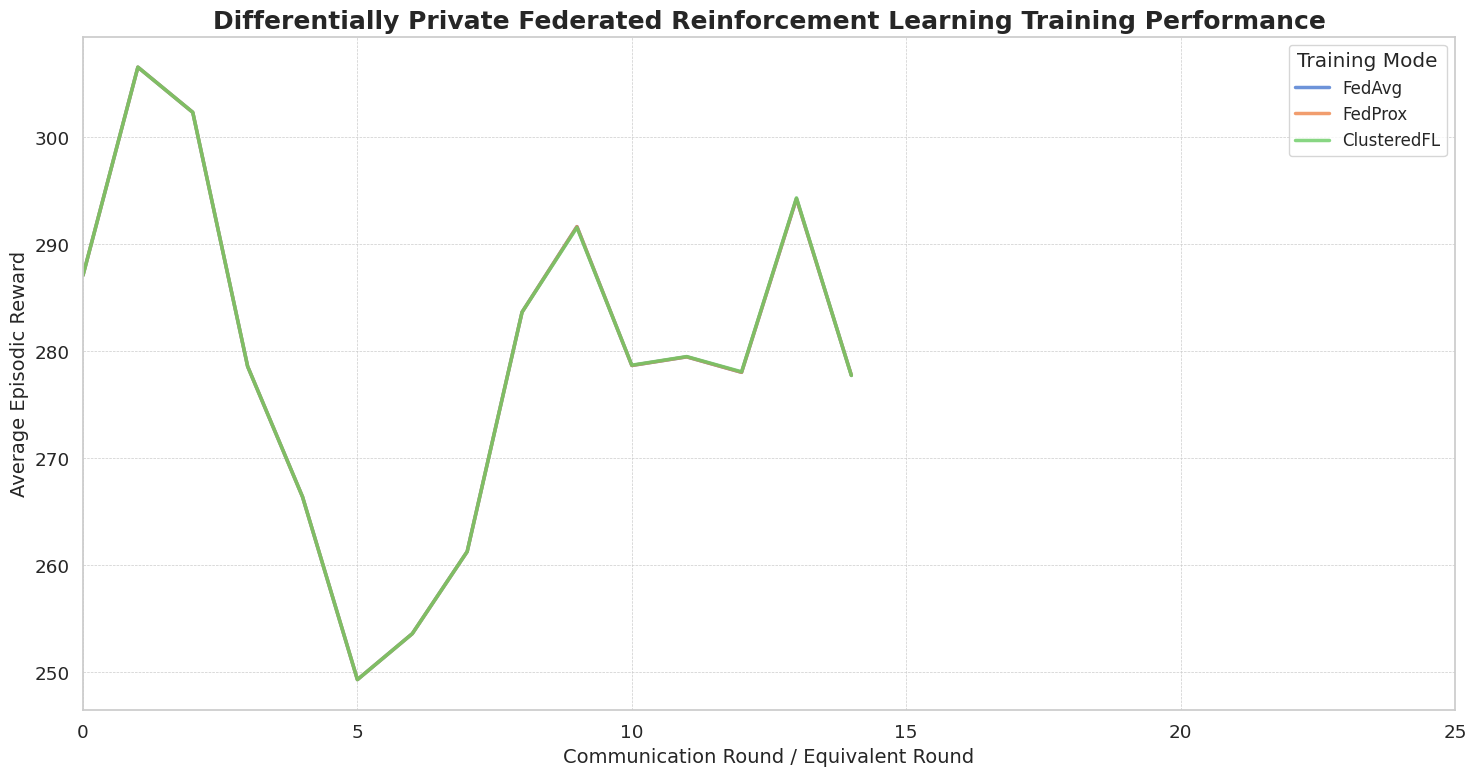

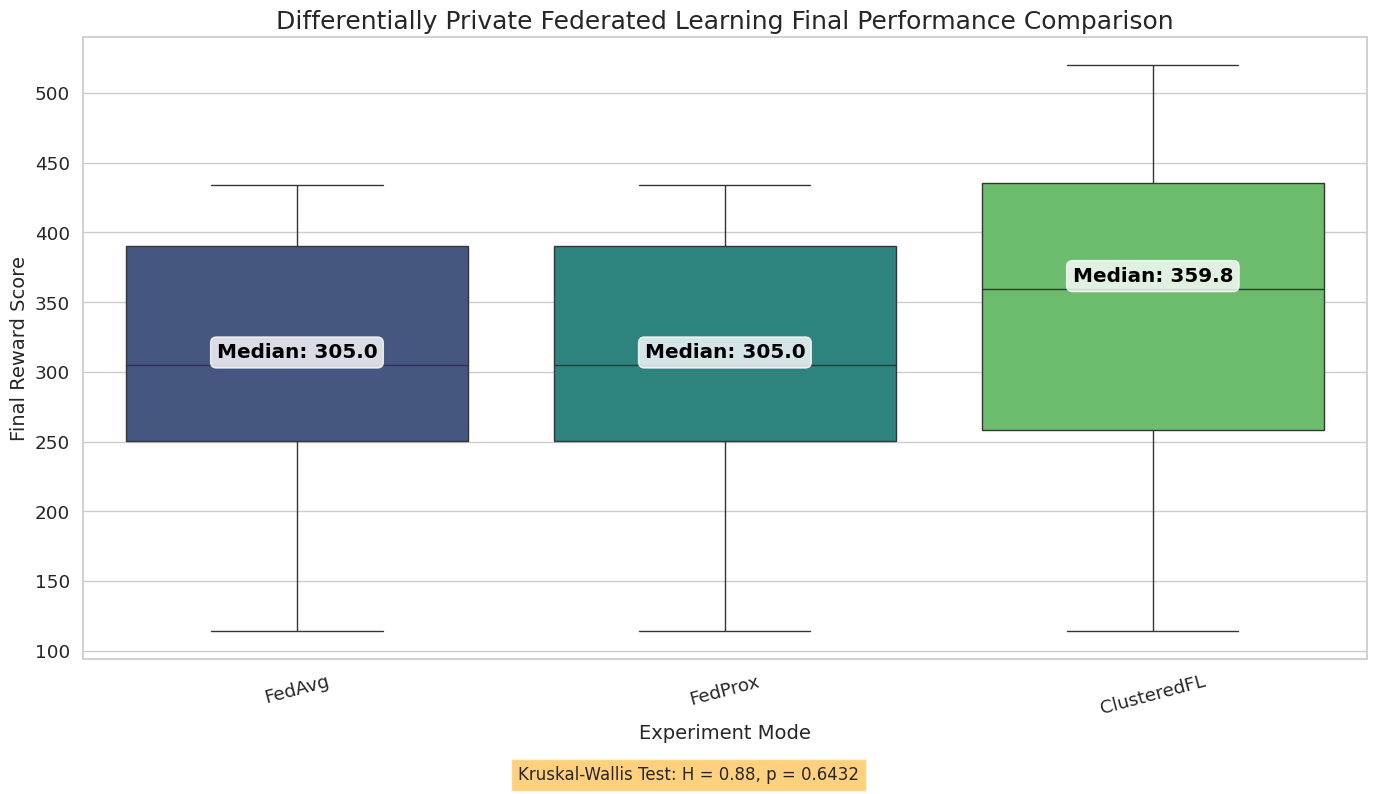

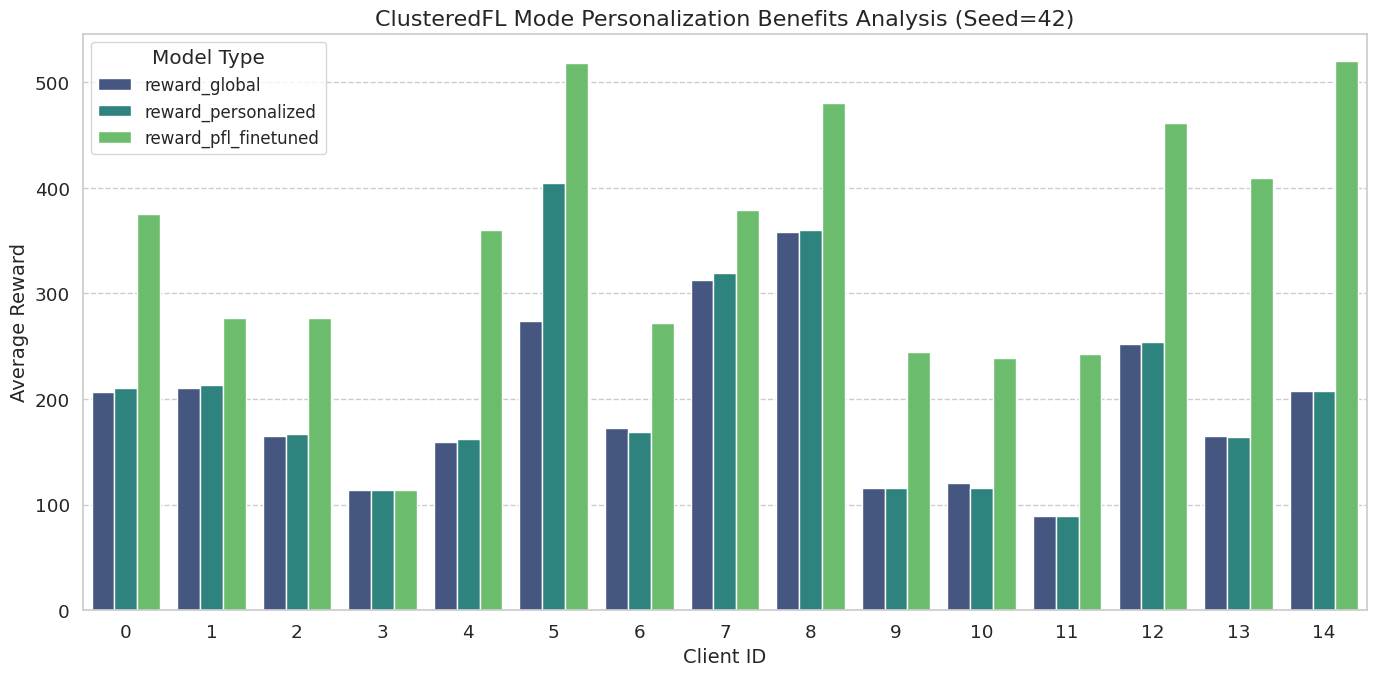

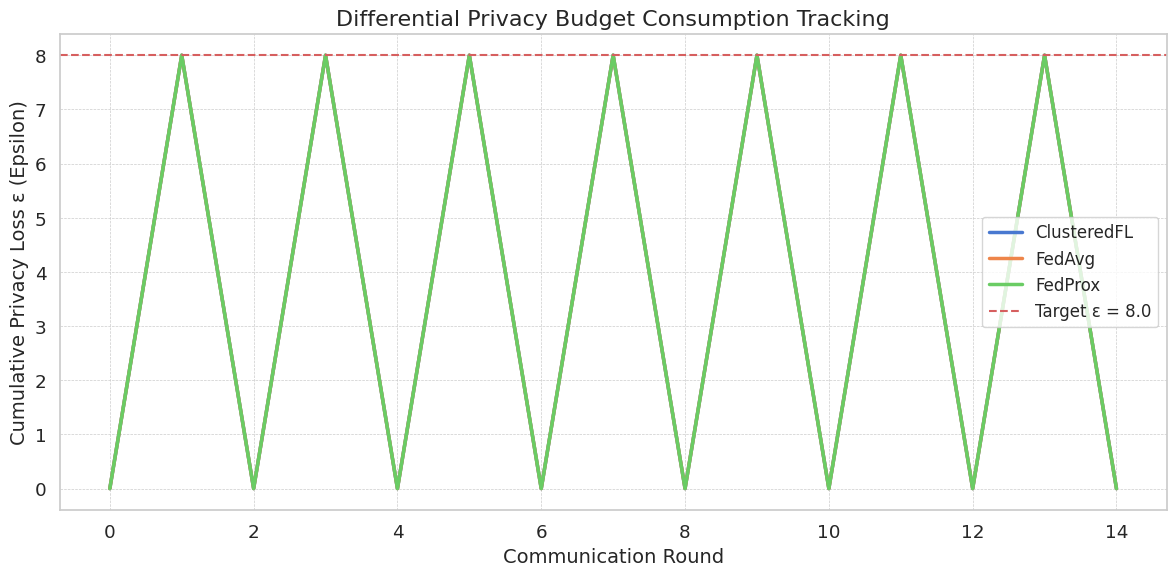

‚úÖ Cell 9: Results Visualization (English Version) completed.
üìÅ Figures saved to: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_virtual_clients/figures


In [16]:
# @title Cell 9: üìä ÁµêÊûúË¶ñË¶∫ÂåñÔºàËã±ÊñáÁâàÔºâ
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"‚ùå Results directory not found: {base_output_dir}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    # Try to load configuration files first
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"üü° Warning: Failed to read config file: {e}")

    # List found files for debugging
    print(f"üîç Searching directory: {base_output_dir}")
    if os.path.exists(base_output_dir):
        print(f"üìÅ Found subdirectories:")
        for item in sorted(os.listdir(base_output_dir)):
            item_path = os.path.join(base_output_dir, item)
            if os.path.isdir(item_path):
                print(f"   üìÇ {item}")
                for subitem in sorted(os.listdir(item_path)):
                    subitem_path = os.path.join(item_path, subitem)
                    if os.path.isdir(subitem_path):
                        print(f"      üìÇ {subitem}")
                        csv_files = glob.glob(os.path.join(subitem_path, "*.csv"))
                        for csv_file in csv_files:
                            print(f"         üìÑ {os.path.basename(csv_file)}")

    for seed_folder in sorted(os.listdir(base_output_dir)):
        if not seed_folder.startswith('seed_'): continue
        try:
            seed = int(seed_folder.split('_')[1])
        except (ValueError, IndexError):
            continue

        for mode_folder in sorted(os.listdir(os.path.join(base_output_dir, seed_folder))):
            exp_path = os.path.join(base_output_dir, seed_folder, mode_folder)
            if not os.path.isdir(exp_path): continue

            eval_files = glob.glob(os.path.join(exp_path, '*_evaluation_results.csv'))
            history_files = glob.glob(os.path.join(exp_path, '*_training_history.csv'))
            privacy_files = glob.glob(os.path.join(exp_path, '*_privacy_costs.csv'))

            def read_and_append(file_list, data_list, mode_name, seed_val):
                if not file_list:
                    print(f"üü° Warning: No files found for {mode_name} (seed {seed_val})")
                    return
                file_path = file_list[0]
                try:
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        df = pd.read_csv(file_path)
                        df['mode'] = mode_name
                        df['seed'] = seed_val
                        data_list.append(df)
                        print(f"‚úÖ Successfully loaded: {mode_name} (seed {seed_val}) - {len(df)} rows")
                    else:
                        print(f"üü° Warning: File is empty or doesn't exist: {file_path}")
                except Exception as e:
                    print(f"üü° Warning: Failed to read file: {file_path}, {e}")

            read_and_append(eval_files, all_evals, mode_folder, seed)
            read_and_append(history_files, all_histories, mode_folder, seed)
            read_and_append(privacy_files, all_privacies, mode_folder, seed)

    return (pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()), \
           (pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()), \
           (pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()), \
           config_data

# --- Visualization Settings ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_virtual_clients")  # Match Cell 8 path
FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

print(f"üîç Loading results from: {BASE_OUTPUT_DIR}")
eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("‚ùå No result files found, cannot generate plots. Please ensure Cell 8 has completed successfully.")
    print(f"üìÅ Expected path: {BASE_OUTPUT_DIR}")
    print(f"üìÅ Path exists: {os.path.exists(BASE_OUTPUT_DIR)}")
else:
    # Corrected settings to match Cell 8
    SEEDS = [42]  # Only one seed
    mode_order = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]  # Removed Centralized

    print(f"‚úÖ Successfully loaded results from {len(eval_df['seed'].unique()) if not eval_df.empty else 0} runs.")
    if not eval_df.empty:
        print(f"üìä Found modes: {sorted(eval_df['mode'].unique())}")
        print(f"üìä Found seeds: {sorted(eval_df['seed'].unique())}")

    # --- Figure 1: Training History Comparison ---
    if not history_df.empty:
        plt.figure(figsize=(15, 8))

        # Only plot existing modes
        available_modes = [mode for mode in mode_order if mode in history_df['mode'].unique()]

        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=available_modes, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)

        plt.title('Differentially Private Federated Reinforcement Learning Training Performance', fontsize=18, weight='bold')
        plt.xlabel('Communication Round / Equivalent Round', fontsize=14)
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim(0, 25)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_dp_eng.png'), dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("üü° Warning: No training history data found")

    # --- Figure 2: Final Performance Comparison ---
    if not eval_df.empty:
        eval_to_plot = eval_df.rename(columns={'reward_pfl_finetuned': 'Final Reward Score'})
        available_modes = [mode for mode in mode_order if mode in eval_to_plot['mode'].unique()]

        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=available_modes, palette="viridis")

        # Add median annotations
        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(available_modes)
        for xtick in ax.get_xticks():
            if xtick < len(available_modes):
                mode_name = available_modes[xtick]
                median_val = medians.get(mode_name)
                if pd.notna(median_val):
                    ax.text(xtick, median_val + 5, f'Median: {median_val:.1f}',
                            horizontalalignment='center', size='medium',
                            color='black', weight='semibold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.title('Differentially Private Federated Learning Final Performance Comparison', fontsize=18)
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score', fontsize=14)
        plt.xticks(rotation=15)

        # Statistical testing
        groups = [eval_to_plot['Final Reward Score'][eval_to_plot['mode'] == m].dropna()
                 for m in available_modes if m in eval_to_plot['mode'].unique()]
        if len(groups) > 1:
            h_stat, p_value = stats.kruskal(*groups)
            plt.figtext(0.5, 0.01, f'Kruskal-Wallis Test: H = {h_stat:.2f}, p = {p_value:.4f}',
                        ha='center', fontsize=12,
                        bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_dp_eng.png'), dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("üü° Warning: No evaluation results data found")

    # --- Figure 3: Personalization Benefit Analysis ---
    if not eval_df.empty:
        first_seed = SEEDS[0]
        # Prefer ClusteredFL, otherwise use the first available mode
        if 'ClusteredFL' in eval_df['mode'].unique():
            target_mode = 'ClusteredFL'
        else:
            target_mode = eval_df['mode'].unique()[0]

        target_eval = eval_df[(eval_df['mode'] == target_mode) & (eval_df['seed'] == first_seed)]

        if not target_eval.empty:
            target_melted = target_eval.melt(
                id_vars=['client_id'],
                value_vars=['reward_global', 'reward_personalized', 'reward_pfl_finetuned'],
                var_name='Model Type', value_name='Average Reward'
            )

            plt.figure(figsize=(14, 7))
            sns.barplot(data=target_melted, x='client_id', y='Average Reward',
                       hue='Model Type', palette='viridis')

            plt.title(f'{target_mode} Mode Personalization Benefits Analysis (Seed={first_seed})', fontsize=16)
            plt.xlabel('Client ID', fontsize=14)
            plt.ylabel('Average Reward', fontsize=14)
            plt.legend(title='Model Type', fontsize=12)
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()

            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit_dp_eng.png'), dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print(f"üü° Warning: No data found for {target_mode} mode")

    # --- Figure 4: Privacy Cost Tracking ---
    if not privacy_df.empty:
        privacy_to_plot = privacy_df[privacy_df['mode'].isin(['FedAvg', 'FedProx', 'ClusteredFL'])]

        if not privacy_to_plot.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=privacy_to_plot, x='round', y='cumulative_epsilon', hue='mode',
                         errorbar=('sd', 1), linewidth=2.5)

            # Add target epsilon line
            if loaded_config and 'dp_target_epsilon' in loaded_config:
                target_eps = loaded_config['dp_target_epsilon']
                plt.axhline(y=target_eps, color='r', linestyle='--',
                           label=f'Target Œµ = {target_eps}')
            else:
                # If no config file, use Cell 8 default
                target_eps = 15.0
                plt.axhline(y=target_eps, color='r', linestyle='--',
                           label=f'Target Œµ = {target_eps}')

            plt.title('Differential Privacy Budget Consumption Tracking', fontsize=16)
            plt.xlabel('Communication Round', fontsize=14)
            plt.ylabel('Cumulative Privacy Loss Œµ (Epsilon)', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'privacy_cost_dp_eng.png'), dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("üü° Warning: No privacy cost data found")
    else:
        print("üü° Warning: No privacy cost files found")

print("‚úÖ Cell 9: Results Visualization (English Version) completed.")
print(f"üìÅ Figures saved to: {FIGURES_OUTPUT_DIR}")


### Êé•‰∏ã‰æÜ
* Êì¥Â±ïÂÆ¢Êà∂Á´ØÊï∏ÈáèÁ†îÁ©∂